In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyarrow.parquet as pq
import pandas as pd
pd.options.display.max_rows = 100
from rich import print
import warnings
import datetime
from astropy.time import Time
import os
import astropy.units as u
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u
import time

In [2]:
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

In [3]:
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"

In [4]:
def angularSeparation(ra1, dec1, ra2, dec2):
    d2r = np.pi/180.
    ra2deg = 1./d2r
    d1 = dec1*d2r,
    d2 = dec2*d2r
    r1 = ra1*d2r
    r2 = ra2*d2r
    a = np.sin((d2-d1)/2.)**2.+np.cos(d1)*np.cos(d2)*np.sin((r2-r1)/2.)**2.
    r = 2*np.arcsin(np.sqrt(a))
    return r*ra2deg

In [5]:
Simbad.add_votable_fields("otype","parallax")

In [6]:
tbl = pd.read_csv('gfcat_visit_table_positions.csv',index_col=None)

In [7]:
# Crossmatch to SIMBAD
for i in np.arange(len(tbl[:])):
    ra,dec=tbl.iloc[i][['ra','dec']].values
    r = Simbad.query_region(coord.SkyCoord(ra,dec,
                            unit=(u.deg, u.deg)),#, frame='icrs'),
                            radius=35/60/60*u.deg)
    try:
        c = coord.SkyCoord(r['RA'],r['DEC'],unit=(u.hourangle, u.deg))
        d = angularSeparation(ra,dec,c.ra.deg,c.dec.deg)
        tbl.loc[i,'simbad_n_match'] = sum(d<17.5/60/60)
        # preserve the order of otype when unique-ifying them
        otype,ix=np.unique(np.array(r['OTYPE'],dtype='str'),return_index=True)
        tbl.loc[i,'simbad_otype'] = ', '.join(np.array(r['OTYPE'],dtype='str')[ix].tolist())
        tbl.loc[i,'simbad_main_id'] = r['MAIN_ID'][0]
        tbl.loc[i,'simbad_distance'] = 1000/r['PLX_VALUE'][0]
        c = coord.SkyCoord(f"{r['RA'][0]} {r['DEC'][0]}", unit=(u.hourangle, u.deg))
        tbl.loc[i,'simbad_match_offset'] = angularSeparation(ra,dec,c.ra.deg,c.dec.deg)[0]*60*60
    except TypeError:
        continue

tbl

,eclipse,obj_id,ra,dec,morphology,simbad_n_match,simbad_otype,simbad_main_id,simbad_distance,simbad_match_offset
0,26808,20726808,185.750875,29.544538,T,1.0,Star,BD+30 2263,688.231246,2.523201
1,21378,39121378,204.877337,30.654018,U,1.0,WhiteDwarf_Candidate,SDSS J133930.42+303915.8,207.913175,2.405300
2,26045,41026045,149.468637,2.338955,U,14.0,"AGN, Galaxy, GroupG, QSO",[VV2006] J095752.3+022021,17667.844523,2.511708
3,23102,42723102,257.253864,58.873073,F,NaN,NaN,NaN,NaN,NaN
4,17070,44617070,247.108147,40.861124,F,2.0,"EmissionG, GroupG, Star",[KB98] Obj J162826+405143,54.691431,2.408693
...,...,...,...,...,...,...,...,...,...,...
1524,43201,99999943201,217.158560,57.753320,U,1.0,Star,HD 238354,293.470286,1.391008
1525,43238,99999943238,243.411230,54.665030,F,NaN,NaN,NaN,NaN,NaN
1526,43828,99999943828,338.340990,-60.930260,F,NaN,NaN,NaN,NaN,NaN
1527,44684,99999944684,308.132040,7.971320,F,0.0,AGN_Candidate,FIRST J203232.8+075805,NaN,21.377871


In [8]:
fn = '/Users/cm/github/gphoton_working/gPhoton/aspect/aspect.parquet'
for i in np.arange(len(tbl))[:]:
    eclipse = int(tbl.iloc[i]['eclipse'])
    aspect = pq.read_table(fn,filters=[('eclipse','=',eclipse)]).to_pandas()
    obstart = aspect.loc[aspect['flags']%2==0]['time'].min()
    #obsend = aspect.loc[aspect['flags']%2==0]['time'].max()
    #obsdur = obsend-obstart
    GPSSECS = 315532800 + 432000
    t = obstart + GPSSECS
    dt = datetime.datetime.fromtimestamp(t)
    tbl.loc[i,'obstart']=int(obstart)
    tbl.loc[i,'datetime_iso']=dt.isoformat().split('.')[0]
    tbl.loc[i,'datetime_decimal']=Time(dt,format='datetime').decimalyear
    ra,dec = tbl.iloc[i]['ra'],tbl.iloc[i]['dec']
    decimal_year = tbl.iloc[i]['datetime_decimal']
    #coord = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs')
    width = u.Quantity(0.2, u.deg)
    height = u.Quantity(0.2, u.deg)
    # the Gaia search API likes to timeout badly, randomly, often... so try to mitigate
    query_success=0
    while query_success==0:
        print(ra,dec)
        try:
            r = Gaia.query_object_async(coordinate=coord.SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree),
                                                          frame='icrs'), width=width, height=height)
            query_success=1
        except TimeoutError:
            pass
    # compute the offset in years between the gaia epoch (2016) and the galex epoch
    year_offset = np.array(r['ref_epoch'])-decimal_year
    # the sky positions of gaia sources in degrees
    ra_gaia,dec_gaia = np.array(r['ra']),np.array(r['dec'])
    # the proper motions of gaia sources, converted from mas to deg per year
    ra_gaia_pm,dec_gaia_pm = np.array(r['pmra'])/60/60/1000,np.array(r['pmdec'])/60/60/1000
    # \"rewind\" the gaia sky positions by the proper motion rate by the difference in epochs
    ra_old = ra_gaia-ra_gaia_pm*year_offset
    dec_old = dec_gaia-dec_gaia_pm*year_offset

    # ignore nan values (usually because missing pm data)
    ix_finite = np.where(np.isfinite(ra_old) & np.isfinite(dec_old) & (np.array(r["parallax_over_error"])>10))
    ix_goodsnr = np.where(np.array(r["parallax_over_error"])>10)
    d = angularSeparation(ra,dec,ra_old[ix_finite],dec_old[ix_finite])
    try:
        ix_match = np.argmin(d)
    except ValueError:
        print(f"No matching Gaia source for {i}")
        continue
    ix = ix_finite[0][ix_match]
    tbl.loc[i,'gaia_source_id']=r[ix]['source_id']
    tbl.loc[i,'gaia_distance_uncorrected']=1000/r[ix_goodsnr]['parallax'][0]
    tbl.loc[i,'gaia_distance']=1000/r[ix]['parallax']
    tbl.loc[i,'pmra']=r[ix]['pmra']
    tbl.loc[i,'pmdec']=r[ix]['pmdec']
    tbl.loc[i,'gaia_ra']=r[ix]['ra']
    tbl.loc[i,'gaia_dec']=r[ix]['dec']
    tbl.loc[i,'gaia_match_offset']=angularSeparation(ra,dec,r[ix]['ra'],r[ix]['dec'])*60*60
    tbl.loc[i,'gaia_match_offset_uncorrected']=angularSeparation(ra,dec,
                                                                 r[ix_goodsnr]['ra'][0],
                                                                 r[ix_goodsnr]['dec'][0])*60*60
    tbl.loc[i,'gaia_n_match']=sum(d<17.5/60/60)
    #tbl.loc[i,'high_pm']='Y' if ix!=0 else 'N' # the best match changed after 'rewinding'
    #time.sleep(1) # to prevent what I interpreted to be timeouts due to rate limiting

185.75087515673096 29.544538360084832

INFO: Query finished. [astroquery.utils.tap.core]


204.877336993835 30.65401769854444

INFO: Query finished. [astroquery.utils.tap.core]


149.46863654276189 2.33895454089582

INFO: Query finished. [astroquery.utils.tap.core]


257.2538642358387 58.87307267921129

INFO: Query finished. [astroquery.utils.tap.core]


247.1081469697158 40.86112361208475

INFO: Query finished. [astroquery.utils.tap.core]


183.5667863016465 0.6230739637083085

INFO: Query finished. [astroquery.utils.tap.core]


210.1126142637797 44.12591119886569

INFO: Query finished. [astroquery.utils.tap.core]


24.151530015934963 -17.789403146044563

INFO: Query finished. [astroquery.utils.tap.core]


4.088267615374891 16.646110673214054

INFO: Query finished. [astroquery.utils.tap.core]


334.5595594313834 24.741788716503905

INFO: Query finished. [astroquery.utils.tap.core]


127.17316138314696 66.03981655959936

INFO: Query finished. [astroquery.utils.tap.core]


43.22924739269435 -37.13983840096211

INFO: Query finished. [astroquery.utils.tap.core]


129.53032800542542 17.782210753207327

INFO: Query finished. [astroquery.utils.tap.core]


216.4831031004444 -1.5655577714510729

INFO: Query finished. [astroquery.utils.tap.core]


140.25989130661762 49.09740343956726

INFO: Query finished. [astroquery.utils.tap.core]


161.43284956387723 5.362619249251627

INFO: Query finished. [astroquery.utils.tap.core]


149.81763359496264 1.8463239197841144

INFO: Query finished. [astroquery.utils.tap.core]


180.5734374046099 28.58685309535768

INFO: Query finished. [astroquery.utils.tap.core]


135.61740354077614 58.803430462866174

INFO: Query finished. [astroquery.utils.tap.core]


53.61611085312483 -27.20649236661851

INFO: Query finished. [astroquery.utils.tap.core]


52.35112718394663 -27.548141314232605

INFO: Query finished. [astroquery.utils.tap.core]


356.9898898604606 -43.335502585607

INFO: Query finished. [astroquery.utils.tap.core]


42.66970182167096 -1.201712261717609

INFO: Query finished. [astroquery.utils.tap.core]


252.41646651849044 34.97159252069071

INFO: Query finished. [astroquery.utils.tap.core]


164.0398863269765 58.98829459887396

INFO: Query finished. [astroquery.utils.tap.core]


11.343012099627174 -1.079986623527892

INFO: Query finished. [astroquery.utils.tap.core]


252.41644607887235 34.97151805551796

INFO: Query finished. [astroquery.utils.tap.core]


123.9123757782765 50.57947621263652

INFO: Query finished. [astroquery.utils.tap.core]


161.4353428198214 5.363765537352688

INFO: Query finished. [astroquery.utils.tap.core]


248.96776633745745 41.802998006570846

INFO: Query finished. [astroquery.utils.tap.core]


149.5049115593077 2.2136545810576576

INFO: Query finished. [astroquery.utils.tap.core]


249.9097384751917 41.11223504008466

INFO: Query finished. [astroquery.utils.tap.core]


187.7319843862152 31.86968483633788

INFO: Query finished. [astroquery.utils.tap.core]


25.833564955051365 4.319712164431756

INFO: Query finished. [astroquery.utils.tap.core]


134.68932455112568 17.765189343390084

INFO: Query finished. [astroquery.utils.tap.core]


334.9813925622775 -8.409477070920135

INFO: Query finished. [astroquery.utils.tap.core]


187.73177569625656 31.86961217574968

INFO: Query finished. [astroquery.utils.tap.core]


187.7318812490493 31.869506503130165

INFO: Query finished. [astroquery.utils.tap.core]


187.2343035740724 1.0610988472396066

INFO: Query finished. [astroquery.utils.tap.core]


200.6161258894085 27.743138961756305

INFO: Query finished. [astroquery.utils.tap.core]


116.16116637988982 29.20593967388688

INFO: Query finished. [astroquery.utils.tap.core]


150.52852966241733 1.986828548462686

INFO: Query finished. [astroquery.utils.tap.core]


187.73163460107008 31.86956702683037

INFO: Query finished. [astroquery.utils.tap.core]


121.89665927343415 26.26942129983201

INFO: Query finished. [astroquery.utils.tap.core]


342.9423665331128 -1.369915809814921

INFO: Query finished. [astroquery.utils.tap.core]


157.19764268747372 61.44919088576974

INFO: Query finished. [astroquery.utils.tap.core]


353.9105400812542 30.25743054706185

INFO: Query finished. [astroquery.utils.tap.core]


143.21101838972248 55.720801958422726

INFO: Query finished. [astroquery.utils.tap.core]


29.787408546809864 27.90704332497761

INFO: Query finished. [astroquery.utils.tap.core]


217.55144837830525 -2.2136851470067254

INFO: Query finished. [astroquery.utils.tap.core]


200.61608950180425 27.74323620230978

INFO: Query finished. [astroquery.utils.tap.core]


160.98720514596013 58.12513329912735

INFO: Query finished. [astroquery.utils.tap.core]


9.866418584426476 -44.52253177143353

INFO: Query finished. [astroquery.utils.tap.core]


187.73172551375123 31.86948681438233

INFO: Query finished. [astroquery.utils.tap.core]


158.64103198037174 57.54181500334116

INFO: Query finished. [astroquery.utils.tap.core]


48.425271175044365 -6.861589582121357

INFO: Query finished. [astroquery.utils.tap.core]


160.98690814630274 58.12532300138593

INFO: Query finished. [astroquery.utils.tap.core]


36.52922917690944 -0.4469940917405347

INFO: Query finished. [astroquery.utils.tap.core]


328.8517751648581 -2.640474347303492

INFO: Query finished. [astroquery.utils.tap.core]


242.15717425075127 55.1007972427098

INFO: Query finished. [astroquery.utils.tap.core]


160.98715957791794 58.12500430956712

INFO: Query finished. [astroquery.utils.tap.core]


249.07768002116208 41.84934146889554

INFO: Query finished. [astroquery.utils.tap.core]


163.81676356697207 -3.5945249681759712

INFO: Query finished. [astroquery.utils.tap.core]


320.0468530783282 -0.5635051947490219

INFO: Query finished. [astroquery.utils.tap.core]


150.07997567955425 1.449384251783966

INFO: Query finished. [astroquery.utils.tap.core]


160.98708348626533 58.125241664635446

INFO: Query finished. [astroquery.utils.tap.core]


160.98713076976284 58.12504828215789

INFO: Query finished. [astroquery.utils.tap.core]


163.816756018753 -3.5944359519544395

INFO: Query finished. [astroquery.utils.tap.core]


160.98711496124457 58.12503018837747

INFO: Query finished. [astroquery.utils.tap.core]


20.853173602019904 -25.774000220157525

INFO: Query finished. [astroquery.utils.tap.core]


24.293193973203543 -17.55103664431994

INFO: Query finished. [astroquery.utils.tap.core]


258.2654379697103 59.801453706900205

INFO: Query finished. [astroquery.utils.tap.core]


140.9856558450962 70.04915222106207

INFO: Query finished. [astroquery.utils.tap.core]


47.25641841465306 -15.818106694368764

INFO: Query finished. [astroquery.utils.tap.core]


160.98728582919492 58.12505932285412

INFO: Query finished. [astroquery.utils.tap.core]


160.9870945132655 58.125103217551896

INFO: Query finished. [astroquery.utils.tap.core]


132.75901980785926 31.359562017214543

INFO: Query finished. [astroquery.utils.tap.core]


160.98732190353527 58.12508332201916

INFO: Query finished. [astroquery.utils.tap.core]


219.7278393560307 33.00529371661522

INFO: Query finished. [astroquery.utils.tap.core]


131.10866592105 51.641298418153504

INFO: Query finished. [astroquery.utils.tap.core]


160.98726942107393 58.1250830541447

INFO: Query finished. [astroquery.utils.tap.core]


160.98728560574625 58.12504939282509

INFO: Query finished. [astroquery.utils.tap.core]


160.9869978024539 58.12524248355015

INFO: Query finished. [astroquery.utils.tap.core]


36.52909671969854 -0.4469909070814041

INFO: Query finished. [astroquery.utils.tap.core]


160.98714406544295 58.12507597760785

INFO: Query finished. [astroquery.utils.tap.core]


160.98700840310406 58.12515632529243

INFO: Query finished. [astroquery.utils.tap.core]


35.906673432891644 -4.668640489149799

INFO: Query finished. [astroquery.utils.tap.core]


160.9874692528255 58.12518043785804

INFO: Query finished. [astroquery.utils.tap.core]


246.4151045396739 19.20532721941301

INFO: Query finished. [astroquery.utils.tap.core]


193.89696565459028 27.0608408980142

INFO: Query finished. [astroquery.utils.tap.core]


222.2422729271446 0.1780336205090912

INFO: Query finished. [astroquery.utils.tap.core]


34.67115893706856 -5.883246007809822

INFO: Query finished. [astroquery.utils.tap.core]


123.04570318685072 3.723139477730206

INFO: Query finished. [astroquery.utils.tap.core]


160.98721033497685 58.12515897317687

INFO: Query finished. [astroquery.utils.tap.core]


224.2926610775424 7.368800449774807

INFO: Query finished. [astroquery.utils.tap.core]


150.50079038381344 66.85710938052667

INFO: Query finished. [astroquery.utils.tap.core]


8.81345590453657 -2.440944326897367

INFO: Query finished. [astroquery.utils.tap.core]


193.16682274741493 28.48595020621985

INFO: Query finished. [astroquery.utils.tap.core]


186.84543457386533 2.6507441040537643

INFO: Query finished. [astroquery.utils.tap.core]


149.26018704428174 1.972751436699285

INFO: Query finished. [astroquery.utils.tap.core]


214.53774730840084 9.365914209557426

INFO: Query finished. [astroquery.utils.tap.core]


8.402582138674168 -43.82101504661363

INFO: Query finished. [astroquery.utils.tap.core]


29.39599598991568 13.890211662328852

INFO: Query finished. [astroquery.utils.tap.core]


126.35885955225756 10.5868706932829

INFO: Query finished. [astroquery.utils.tap.core]


203.04785916566496 15.932602181291283

INFO: Query finished. [astroquery.utils.tap.core]


249.90969866826703 41.11239733650714

INFO: Query finished. [astroquery.utils.tap.core]


216.6884317254182 34.45648447918394

INFO: Query finished. [astroquery.utils.tap.core]


8.402521321756948 -43.82100870908823

INFO: Query finished. [astroquery.utils.tap.core]


150.01547558768712 33.21740557910228

INFO: Query finished. [astroquery.utils.tap.core]


214.944026452692 52.99479374059455

INFO: Query finished. [astroquery.utils.tap.core]


172.9803216379372 -34.60798903369256

INFO: Query finished. [astroquery.utils.tap.core]


24.231304960940733 7.274561794796727

INFO: Query finished. [astroquery.utils.tap.core]


8.402590088318744 -43.82101732410058

INFO: Query finished. [astroquery.utils.tap.core]


160.98710563630402 58.125100439460965

INFO: Query finished. [astroquery.utils.tap.core]


8.40306274327182 -43.82091876063833

INFO: Query finished. [astroquery.utils.tap.core]


123.11033056661192 3.5552578642600063

INFO: Query finished. [astroquery.utils.tap.core]


187.9121814565819 8.232733914302672

INFO: Query finished. [astroquery.utils.tap.core]


158.47130644655974 58.78177868645308

INFO: Query finished. [astroquery.utils.tap.core]


242.2643703991792 52.94369856333908

INFO: Query finished. [astroquery.utils.tap.core]


214.9445700410324 52.99514763542772

INFO: Query finished. [astroquery.utils.tap.core]


53.00925035031003 -27.04798534305836

INFO: Query finished. [astroquery.utils.tap.core]


330.82052134069744 -64.05822018788135

INFO: Query finished. [astroquery.utils.tap.core]


158.4711206106625 58.78147257902717

INFO: Query finished. [astroquery.utils.tap.core]


13.543268536808906 5.157644622365935

INFO: Query finished. [astroquery.utils.tap.core]


348.470247492763 14.473899455459602

INFO: Query finished. [astroquery.utils.tap.core]


158.47102931574142 58.78132063042531

INFO: Query finished. [astroquery.utils.tap.core]


162.4289113880476 6.021116308273012

INFO: Query finished. [astroquery.utils.tap.core]


34.942156325430375 -2.6506368105716347

INFO: Query finished. [astroquery.utils.tap.core]


160.98732583565183 58.12518086186384

INFO: Query finished. [astroquery.utils.tap.core]


202.21195789242068 5.48025718574479

INFO: Query finished. [astroquery.utils.tap.core]


162.12001277843137 58.86648064250592

INFO: Query finished. [astroquery.utils.tap.core]


348.20382442194 1.2606350180975248

INFO: Query finished. [astroquery.utils.tap.core]


8.402602412243954 -43.821005338699

INFO: Query finished. [astroquery.utils.tap.core]


158.47119154764562 58.78148349730333

INFO: Query finished. [astroquery.utils.tap.core]


8.402566452817396 -43.82106099653566

INFO: Query finished. [astroquery.utils.tap.core]


163.14036331509837 -6.08648443848276

INFO: Query finished. [astroquery.utils.tap.core]


8.402553314187744 -43.82090281850729

INFO: Query finished. [astroquery.utils.tap.core]


4.7223041265839525 -11.209361529859391

INFO: Query finished. [astroquery.utils.tap.core]


193.8969312774387 27.06094755369753

INFO: Query finished. [astroquery.utils.tap.core]


158.4709610482206 58.78145885024073

INFO: Query finished. [astroquery.utils.tap.core]


158.4712149269739 58.78141703282887

INFO: Query finished. [astroquery.utils.tap.core]


302.64406130295714 6.536384323088601

INFO: Query finished. [astroquery.utils.tap.core]


184.51491383417152 6.419057552262589

INFO: Query finished. [astroquery.utils.tap.core]


158.4712159770858 58.78124380654455

INFO: Query finished. [astroquery.utils.tap.core]


214.3959605009753 52.46945408709995

INFO: Query finished. [astroquery.utils.tap.core]


141.32601575586853 70.3856983204677

INFO: Query finished. [astroquery.utils.tap.core]


138.79788106167507 29.56305886071648

INFO: Query finished. [astroquery.utils.tap.core]


36.15769405769368 0.6664748146119618

INFO: Query finished. [astroquery.utils.tap.core]


158.47093565735435 58.781504742066176

INFO: Query finished. [astroquery.utils.tap.core]


147.73646813655884 69.13091468577517

INFO: Query finished. [astroquery.utils.tap.core]


353.38026768650536 -55.44381359145872

INFO: Query finished. [astroquery.utils.tap.core]


158.47113134950726 58.78150658771672

INFO: Query finished. [astroquery.utils.tap.core]


158.47109941983268 58.78139393330552

INFO: Query finished. [astroquery.utils.tap.core]


171.05581131684033 -8.915372467166964

INFO: Query finished. [astroquery.utils.tap.core]


180.7314265618107 18.75382682482717

INFO: Query finished. [astroquery.utils.tap.core]


34.6250451370677 -4.920932645525115

INFO: Query finished. [astroquery.utils.tap.core]


45.47219348859936 -33.12708522142131

INFO: Query finished. [astroquery.utils.tap.core]


358.98092114890767 -13.35685217053451

INFO: Query finished. [astroquery.utils.tap.core]


269.4208286187863 18.06518683445224

INFO: Query finished. [astroquery.utils.tap.core]


158.47106224267014 58.78156694073074

INFO: Query finished. [astroquery.utils.tap.core]


35.061962639679926 -3.1236317357084715

INFO: Query finished. [astroquery.utils.tap.core]


158.4710782971047 58.78132974725745

INFO: Query finished. [astroquery.utils.tap.core]


158.47105471896842 58.78149894328799

INFO: Query finished. [astroquery.utils.tap.core]


359.0859448819432 -4.492256809153911

INFO: Query finished. [astroquery.utils.tap.core]


22.30269967337406 -22.228472717404284

INFO: Query finished. [astroquery.utils.tap.core]


158.47110113637083 58.781505998743945

INFO: Query finished. [astroquery.utils.tap.core]


158.47114058565177 58.78130295968785

INFO: Query finished. [astroquery.utils.tap.core]


149.13796641356336 1.052369304686707

INFO: Query finished. [astroquery.utils.tap.core]


158.47139961919228 58.78121204189205

INFO: Query finished. [astroquery.utils.tap.core]


158.47107000041947 58.78147467638006

INFO: Query finished. [astroquery.utils.tap.core]


156.85876009529616 71.06525673588423

INFO: Query finished. [astroquery.utils.tap.core]


158.47137290856978 58.78146526380017

INFO: Query finished. [astroquery.utils.tap.core]


170.1927691624218 26.848333037086224

INFO: Query finished. [astroquery.utils.tap.core]


8.544446455729457 -44.08407501602764

INFO: Query finished. [astroquery.utils.tap.core]


244.0990110361113 55.09756818332045

INFO: Query finished. [astroquery.utils.tap.core]


188.6721301593027 61.90652828079876

INFO: Query finished. [astroquery.utils.tap.core]


243.82015393450632 55.37447006776144

INFO: Query finished. [astroquery.utils.tap.core]


249.7117528999779 40.40220090910336

INFO: Query finished. [astroquery.utils.tap.core]


256.723112866486 37.4085384066824

INFO: Query finished. [astroquery.utils.tap.core]


218.94354452245832 34.43395495786708

INFO: Query finished. [astroquery.utils.tap.core]


158.47099003396715 58.78163475812977

INFO: Query finished. [astroquery.utils.tap.core]


214.58009062356305 52.83487964966726

INFO: Query finished. [astroquery.utils.tap.core]


333.4473902890875 -17.728159945539606

INFO: Query finished. [astroquery.utils.tap.core]


218.751423025106 -0.7686851210308413

INFO: Query finished. [astroquery.utils.tap.core]


211.96666577462847 53.857725203172784

INFO: Query finished. [astroquery.utils.tap.core]


240.44855389805647 55.609472259454215

INFO: Query finished. [astroquery.utils.tap.core]


146.8007290257096 51.90225490274736

INFO: Query finished. [astroquery.utils.tap.core]


162.18486161260907 58.2603427396972

INFO: Query finished. [astroquery.utils.tap.core]


312.6915053574669 -0.2546556411255166

INFO: Query finished. [astroquery.utils.tap.core]


211.06592416923385 0.509307376856818

INFO: Query finished. [astroquery.utils.tap.core]


163.81679906751498 -3.5945370164722044

INFO: Query finished. [astroquery.utils.tap.core]


240.01648081384675 5.728357203192212

INFO: Query finished. [astroquery.utils.tap.core]


8.40255100031225 -43.820953555447325

INFO: Query finished. [astroquery.utils.tap.core]


188.85009216997025 61.69192185359419

INFO: Query finished. [astroquery.utils.tap.core]


166.93104644185706 7.939772251965111

INFO: Query finished. [astroquery.utils.tap.core]


200.7243299096677 27.472824567779355

INFO: Query finished. [astroquery.utils.tap.core]


150.38916124830288 1.7241274187763092

INFO: Query finished. [astroquery.utils.tap.core]


171.055830869718 -8.91543856599119

INFO: Query finished. [astroquery.utils.tap.core]


158.47113281053603 58.78145058823153

INFO: Query finished. [astroquery.utils.tap.core]


165.62247375886085 28.56653925232654

INFO: Query finished. [astroquery.utils.tap.core]


343.9831353662063 -56.11752136381969

INFO: Query finished. [astroquery.utils.tap.core]


214.57999124521675 52.83490817007582

INFO: Query finished. [astroquery.utils.tap.core]


35.78717788653571 -30.72896288218508

INFO: Query finished. [astroquery.utils.tap.core]


162.18514005814845 58.26031805683229

INFO: Query finished. [astroquery.utils.tap.core]


215.09798336476564 52.43221514913571

INFO: Query finished. [astroquery.utils.tap.core]


352.5708233364021 -8.64422609662166

INFO: Query finished. [astroquery.utils.tap.core]


8.40274874102068 -43.82087564261756

INFO: Query finished. [astroquery.utils.tap.core]


8.402643329060892 -43.821061061486205

INFO: Query finished. [astroquery.utils.tap.core]


202.04475108562 10.47477506974137

INFO: Query finished. [astroquery.utils.tap.core]


189.99887072844533 11.50987173740516

INFO: Query finished. [astroquery.utils.tap.core]


159.75360392814022 61.181407072669536

INFO: Query finished. [astroquery.utils.tap.core]


158.47149766556768 58.78148897764339

INFO: Query finished. [astroquery.utils.tap.core]


187.7319381691504 31.869480139097675

INFO: Query finished. [astroquery.utils.tap.core]


15.643486567201888 3.4329618649900726

INFO: Query finished. [astroquery.utils.tap.core]


158.47134072223537 58.78125834895231

INFO: Query finished. [astroquery.utils.tap.core]


149.49560741034853 2.083823553400393

INFO: Query finished. [astroquery.utils.tap.core]


214.5799890563458 52.83492305937363

INFO: Query finished. [astroquery.utils.tap.core]


206.5116235968577 23.81506111493716

INFO: Query finished. [astroquery.utils.tap.core]


164.52921121055647 59.66571281306465

INFO: Query finished. [astroquery.utils.tap.core]


153.73418909146815 61.17030144575962

INFO: Query finished. [astroquery.utils.tap.core]


332.0317323984797 2.271722392326639

INFO: Query finished. [astroquery.utils.tap.core]


245.6488107005576 35.603066683114804

INFO: Query finished. [astroquery.utils.tap.core]


162.6693375660162 57.96355150152138

INFO: Query finished. [astroquery.utils.tap.core]


251.6309376111193 34.58094699876886

INFO: Query finished. [astroquery.utils.tap.core]


244.2735002039635 55.26796345376764

INFO: Query finished. [astroquery.utils.tap.core]


35.33072089914036 -2.969874821015828

INFO: Query finished. [astroquery.utils.tap.core]


145.55573384977754 57.561605909387126

INFO: Query finished. [astroquery.utils.tap.core]


286.70696029909345 -42.95721533226781

INFO: Query finished. [astroquery.utils.tap.core]


123.87210725456404 51.50024247137642

INFO: Query finished. [astroquery.utils.tap.core]


9.06514471617698 1.3888732566749018

INFO: Query finished. [astroquery.utils.tap.core]


253.6883780358344 42.54029001452376

INFO: Query finished. [astroquery.utils.tap.core]


158.47116280015874 58.78149900839125

INFO: Query finished. [astroquery.utils.tap.core]


242.04049855643063 54.35815621644172

INFO: Query finished. [astroquery.utils.tap.core]


188.8036593520012 62.29553336858154

INFO: Query finished. [astroquery.utils.tap.core]


317.109116604856 15.646508134479722

INFO: Query finished. [astroquery.utils.tap.core]


328.4745447184803 -18.46382198032636

INFO: Query finished. [astroquery.utils.tap.core]


244.27374891674984 55.26788573169326

INFO: Query finished. [astroquery.utils.tap.core]


218.9434214693834 34.43395671088091

INFO: Query finished. [astroquery.utils.tap.core]


345.5748084309847 13.46363651339484

INFO: Query finished. [astroquery.utils.tap.core]


39.981682481347 -7.482213244692814

INFO: Query finished. [astroquery.utils.tap.core]


243.411257478364 54.66438988191649

INFO: Query finished. [astroquery.utils.tap.core]


158.47126467368508 58.78150987948295

INFO: Query finished. [astroquery.utils.tap.core]


193.897957176284 27.06347131372637

INFO: Query finished. [astroquery.utils.tap.core]


37.307062460354885 -10.162283482491295

INFO: Query finished. [astroquery.utils.tap.core]


258.0162016858898 52.89809246836946

INFO: Query finished. [astroquery.utils.tap.core]


208.19308103244413 31.54966187513861

INFO: Query finished. [astroquery.utils.tap.core]


194.0989258430913 29.21717038382667

INFO: Query finished. [astroquery.utils.tap.core]


72.97649428145667 -2.496481900526168

INFO: Query finished. [astroquery.utils.tap.core]


356.63439308076283 -0.5448494566832629

INFO: Query finished. [astroquery.utils.tap.core]


188.71016381554725 62.170171551937386

INFO: Query finished. [astroquery.utils.tap.core]


134.09608263044487 28.667034311018767

INFO: Query finished. [astroquery.utils.tap.core]


200.958351494998 27.724031677672524

INFO: Query finished. [astroquery.utils.tap.core]


251.5212914610813 35.14451252007462

INFO: Query finished. [astroquery.utils.tap.core]


53.9422698904392 -29.03646562672804

INFO: Query finished. [astroquery.utils.tap.core]


242.3158845916221 25.52097758828967

INFO: Query finished. [astroquery.utils.tap.core]


131.7212104274841 44.44378107409174

INFO: Query finished. [astroquery.utils.tap.core]


311.1994896525406 -0.0692173752448896

INFO: Query finished. [astroquery.utils.tap.core]


160.98711685241793 58.12513749962889

INFO: Query finished. [astroquery.utils.tap.core]


245.1294468847624 13.83222037660153

INFO: Query finished. [astroquery.utils.tap.core]


340.9326320019935 19.28115586270514

INFO: Query finished. [astroquery.utils.tap.core]


158.4709722837556 58.78173571090724

INFO: Query finished. [astroquery.utils.tap.core]


149.96809071900623 2.7799675934534283

INFO: Query finished. [astroquery.utils.tap.core]


35.18730679871327 -5.050188478067659

INFO: Query finished. [astroquery.utils.tap.core]


247.57341902640368 40.90671515630317

INFO: Query finished. [astroquery.utils.tap.core]


24.565350978784725 -17.673449608238712

INFO: Query finished. [astroquery.utils.tap.core]


19.666436097299616 11.85642939343505

INFO: Query finished. [astroquery.utils.tap.core]


9.149621773486512 42.30479832954273

INFO: Query finished. [astroquery.utils.tap.core]


342.16723415931654 -6.712819880603591

INFO: Query finished. [astroquery.utils.tap.core]


51.86588656527128 -6.96506006008199

INFO: Query finished. [astroquery.utils.tap.core]


244.2734580137337 55.26813040699346

INFO: Query finished. [astroquery.utils.tap.core]


8.40293809022959 -43.82125987601831

INFO: Query finished. [astroquery.utils.tap.core]


157.17538937012213 57.14418518023189

INFO: Query finished. [astroquery.utils.tap.core]


186.491513672997 33.78054532818442

INFO: Query finished. [astroquery.utils.tap.core]


255.9708369263361 32.19583947200172

INFO: Query finished. [astroquery.utils.tap.core]


52.9713040568542 -27.43034978121681

INFO: Query finished. [astroquery.utils.tap.core]


193.8969152081335 27.061006287955664

INFO: Query finished. [astroquery.utils.tap.core]


249.9098144368231 41.11226887302188

INFO: Query finished. [astroquery.utils.tap.core]


324.75569950747 -24.15917143815341

INFO: Query finished. [astroquery.utils.tap.core]


53.94227402262188 -29.036425133352488

INFO: Query finished. [astroquery.utils.tap.core]


184.5867536826165 6.237310655455514

INFO: Query finished. [astroquery.utils.tap.core]


136.6013816965605 -0.4081700868467556

INFO: Query finished. [astroquery.utils.tap.core]


251.40292999642625 -1.775913212969962

INFO: Query finished. [astroquery.utils.tap.core]


164.03998466687307 58.9884702151809

INFO: Query finished. [astroquery.utils.tap.core]


35.35919635490366 -3.233293336691885

INFO: Query finished. [astroquery.utils.tap.core]


242.72339071462147 53.652092367920446

INFO: Query finished. [astroquery.utils.tap.core]


219.25612926475176 63.90432324430515

INFO: Query finished. [astroquery.utils.tap.core]


30.405681586574484 -8.116733829992407

INFO: Query finished. [astroquery.utils.tap.core]


130.42675074186246 49.42094734701219

INFO: Query finished. [astroquery.utils.tap.core]


147.0600774307257 67.34190276501795

INFO: Query finished. [astroquery.utils.tap.core]


162.1850170460163 58.260481839875865

INFO: Query finished. [astroquery.utils.tap.core]


80.25975871188855 -50.03300174227426

INFO: Query finished. [astroquery.utils.tap.core]


244.27332844399456 55.26810945324137

INFO: Query finished. [astroquery.utils.tap.core]


124.20960526245844 71.16635520147753

INFO: Query finished. [astroquery.utils.tap.core]


185.3627337044065 30.64246155872777

INFO: Query finished. [astroquery.utils.tap.core]


162.33936320951966 59.25277295994422

INFO: Query finished. [astroquery.utils.tap.core]


244.2738149461449 55.267786941269854

INFO: Query finished. [astroquery.utils.tap.core]


17.67202794835505 -36.82459927891627

INFO: Query finished. [astroquery.utils.tap.core]


227.4924196373768 -2.4343267725727675

INFO: Query finished. [astroquery.utils.tap.core]


243.41137423745528 54.66411421831782

INFO: Query finished. [astroquery.utils.tap.core]


338.67516671124 0.4455314775528782

INFO: Query finished. [astroquery.utils.tap.core]


193.3330883694783 -10.17607847684501

INFO: Query finished. [astroquery.utils.tap.core]


126.06206201846771 47.36555366520487

INFO: Query finished. [astroquery.utils.tap.core]


131.26122136403458 45.71312622159173

INFO: Query finished. [astroquery.utils.tap.core]


230.1924750172311 4.130746781615206

INFO: Query finished. [astroquery.utils.tap.core]


161.78227181061374 5.563370372773152

INFO: Query finished. [astroquery.utils.tap.core]


133.7384669750874 22.359698223643683

INFO: Query finished. [astroquery.utils.tap.core]


53.94241909866168 -29.036548721424467

INFO: Query finished. [astroquery.utils.tap.core]


133.00935581471927 -5.775061613769047

INFO: Query finished. [astroquery.utils.tap.core]


53.87448643910644 -28.30787014220212

INFO: Query finished. [astroquery.utils.tap.core]


246.0951304231078 19.989080950217907

INFO: Query finished. [astroquery.utils.tap.core]


188.7098883212145 62.17016247432283

INFO: Query finished. [astroquery.utils.tap.core]


244.2736660020516 55.26803708407628

INFO: Query finished. [astroquery.utils.tap.core]


60.38940173176805 -5.359695555867169

INFO: Query finished. [astroquery.utils.tap.core]


53.0090514169725 -27.04804369771685

INFO: Query finished. [astroquery.utils.tap.core]


221.3355775521284 8.858559179235234

INFO: Query finished. [astroquery.utils.tap.core]


138.06367437562372 -10.20139755278834

INFO: Query finished. [astroquery.utils.tap.core]


53.0090736383368 -27.04807294311661

INFO: Query finished. [astroquery.utils.tap.core]


216.0771103084889 32.90872660775999

INFO: Query finished. [astroquery.utils.tap.core]


137.00520591067396 64.94998474434034

INFO: Query finished. [astroquery.utils.tap.core]


338.8780749019883 14.481721895251148

INFO: Query finished. [astroquery.utils.tap.core]


149.50476833303458 2.213578371627247

INFO: Query finished. [astroquery.utils.tap.core]


358.81120950819184 0.0559649497244649

INFO: Query finished. [astroquery.utils.tap.core]


200.62128108778305 1.0143362159763545

INFO: Query finished. [astroquery.utils.tap.core]


31.334109564602645 -5.811704999189704

INFO: Query finished. [astroquery.utils.tap.core]


9.268527410048517 42.41029400622329

INFO: Query finished. [astroquery.utils.tap.core]


343.0351706572345 -39.97206343323212

INFO: Query finished. [astroquery.utils.tap.core]


219.0958460513777 34.86055746994361

INFO: Query finished. [astroquery.utils.tap.core]


188.8501139144643 61.69182945976573

INFO: Query finished. [astroquery.utils.tap.core]


129.13670387479465 16.590928231581806

INFO: Query finished. [astroquery.utils.tap.core]


353.6918216469755 -25.1674999751848

INFO: Query finished. [astroquery.utils.tap.core]


37.42383347361635 -5.787810602162859

INFO: Query finished. [astroquery.utils.tap.core]


53.07366536511783 -27.3187281742699

INFO: Query finished. [astroquery.utils.tap.core]


214.57998986586423 52.83499795051259

INFO: Query finished. [astroquery.utils.tap.core]


214.74999698635887 52.302312788989

INFO: Query finished. [astroquery.utils.tap.core]


182.81186467358947 47.82861152989862

INFO: Query finished. [astroquery.utils.tap.core]


219.55623233099988 5.839529719241848

INFO: Query finished. [astroquery.utils.tap.core]


333.6128668951421 -17.79430158181385

INFO: Query finished. [astroquery.utils.tap.core]


66.51843748455464 17.12041907707773

INFO: Query finished. [astroquery.utils.tap.core]


176.7730355120216 -0.9151090440056716

INFO: Query finished. [astroquery.utils.tap.core]


244.27359165736195 55.26756112632157

INFO: Query finished. [astroquery.utils.tap.core]


116.80857726473194 50.34379859479463

INFO: Query finished. [astroquery.utils.tap.core]


211.67334604733384 17.826545631633778

INFO: Query finished. [astroquery.utils.tap.core]


157.17564876577424 57.14416128488082

INFO: Query finished. [astroquery.utils.tap.core]


219.2289721982032 34.066298107245885

INFO: Query finished. [astroquery.utils.tap.core]


328.34111514911746 4.67195404999461

INFO: Query finished. [astroquery.utils.tap.core]


127.670320180401 4.361789912995566

INFO: Query finished. [astroquery.utils.tap.core]


186.93622974128093 8.700776276864064

INFO: Query finished. [astroquery.utils.tap.core]


157.1961345874655 57.40915337406929

INFO: Query finished. [astroquery.utils.tap.core]


193.33323155557235 -10.176094596287076

INFO: Query finished. [astroquery.utils.tap.core]


116.44441911269966 46.88073624661758

INFO: Query finished. [astroquery.utils.tap.core]


147.06819916251197 51.24723624112604

INFO: Query finished. [astroquery.utils.tap.core]


64.20601634494317 -50.17500948205548

INFO: Query finished. [astroquery.utils.tap.core]


200.9378820511339 38.3527027004165

INFO: Query finished. [astroquery.utils.tap.core]


127.6704975086312 4.361911038791507

INFO: Query finished. [astroquery.utils.tap.core]


19.522935371720976 -75.1909756697136

INFO: Query finished. [astroquery.utils.tap.core]


No matching Gaia source for 354

242.19146024760505 55.877536607669136

INFO: Query finished. [astroquery.utils.tap.core]


217.5663426752592 32.52276205799026

INFO: Query finished. [astroquery.utils.tap.core]


244.2734707223165 55.26813353218617

INFO: Query finished. [astroquery.utils.tap.core]


124.78061229177396 24.789098064676548

INFO: Query finished. [astroquery.utils.tap.core]


214.568719015126 52.49423729915706

INFO: Query finished. [astroquery.utils.tap.core]


158.47107107147718 58.78177173611088

INFO: Query finished. [astroquery.utils.tap.core]


36.04892133818824 -5.417619168132821

INFO: Query finished. [astroquery.utils.tap.core]


327.3170106117904 4.511959071127884

INFO: Query finished. [astroquery.utils.tap.core]


197.2487102887814 28.970924786143947

INFO: Query finished. [astroquery.utils.tap.core]


143.4714433638861 77.72108722944407

INFO: Query finished. [astroquery.utils.tap.core]


142.40078793160444 70.80907900879376

INFO: Query finished. [astroquery.utils.tap.core]


219.2290753336074 34.06624568999856

INFO: Query finished. [astroquery.utils.tap.core]


159.75453298535177 13.524652885424029

INFO: Query finished. [astroquery.utils.tap.core]


329.9827449164988 -72.68643170027971

INFO: Query finished. [astroquery.utils.tap.core]


201.098720629375 27.6221162990944

INFO: Query finished. [astroquery.utils.tap.core]


141.63100041657324 4.993102992853955

INFO: Query finished. [astroquery.utils.tap.core]


7.327248482811633 -44.64901156180029

INFO: Query finished. [astroquery.utils.tap.core]


186.6350865234676 33.788515366099446

INFO: Query finished. [astroquery.utils.tap.core]


66.51846073303993 17.120395417571487

INFO: Query finished. [astroquery.utils.tap.core]


4.343350963617087 16.509804857369097

INFO: Query finished. [astroquery.utils.tap.core]


37.25195368786262 -41.12620306430502

INFO: Query finished. [astroquery.utils.tap.core]


144.02057894550782 44.67769765720286

INFO: Query finished. [astroquery.utils.tap.core]


192.27934823713235 -1.0729172787651158

INFO: Query finished. [astroquery.utils.tap.core]


21.48489003701724 -35.721451099824485

INFO: Query finished. [astroquery.utils.tap.core]


351.5077923948449 0.4657237896720382

INFO: Query finished. [astroquery.utils.tap.core]


251.9250367956305 34.95874981538987

INFO: Query finished. [astroquery.utils.tap.core]


212.5034476217513 52.41462272584023

INFO: Query finished. [astroquery.utils.tap.core]


33.55343783800404 -3.96270405510755

INFO: Query finished. [astroquery.utils.tap.core]


142.4008186477766 70.8089192071791

INFO: Query finished. [astroquery.utils.tap.core]


219.2290275492704 34.06626844182466

INFO: Query finished. [astroquery.utils.tap.core]


188.3193890564819 9.021127286685434

INFO: Query finished. [astroquery.utils.tap.core]


36.13565384285686 -4.510637609429458

INFO: Query finished. [astroquery.utils.tap.core]


197.395818321163 28.984424255005884

INFO: Query finished. [astroquery.utils.tap.core]


218.0718203819185 34.67096552533572

INFO: Query finished. [astroquery.utils.tap.core]


244.27385350227132 55.267481979853024

INFO: Query finished. [astroquery.utils.tap.core]


317.10096904496663 1.0341401734565434

INFO: Query finished. [astroquery.utils.tap.core]


169.40779537447477 -17.326425502145764

INFO: Query finished. [astroquery.utils.tap.core]


155.9166176719679 2.658255827519114

INFO: Query finished. [astroquery.utils.tap.core]


36.27630398507478 -4.479838817004319

INFO: Query finished. [astroquery.utils.tap.core]


244.27340392339443 55.26844564938492

INFO: Query finished. [astroquery.utils.tap.core]


214.95756627682604 53.09823931828005

INFO: Query finished. [astroquery.utils.tap.core]


251.92510410080524 34.95880534964501

INFO: Query finished. [astroquery.utils.tap.core]


335.8303070338318 -8.879690524816079

INFO: Query finished. [astroquery.utils.tap.core]


144.90757187342228 3.39109943257916

INFO: Query finished. [astroquery.utils.tap.core]


250.13764601884168 40.61786114424368

INFO: Query finished. [astroquery.utils.tap.core]


33.55370328870264 -3.962774892983626

INFO: Query finished. [astroquery.utils.tap.core]


333.6129206518221 -17.794299675618735

INFO: Query finished. [astroquery.utils.tap.core]


244.3555678922998 54.89822774899882

INFO: Query finished. [astroquery.utils.tap.core]


186.63519511069788 33.788560835911746

INFO: Query finished. [astroquery.utils.tap.core]


10.346021894898668 -42.07784477182207

INFO: Query finished. [astroquery.utils.tap.core]


250.1378103077272 40.61801307388952

INFO: Query finished. [astroquery.utils.tap.core]


210.9882356615213 -15.020109370626512

INFO: Query finished. [astroquery.utils.tap.core]


242.3835173979516 53.67928770868846

INFO: Query finished. [astroquery.utils.tap.core]


29.196993709013714 -0.3539083285197469

INFO: Query finished. [astroquery.utils.tap.core]


158.9099722027002 58.26326239868067

INFO: Query finished. [astroquery.utils.tap.core]


347.08198516361153 -15.41029899773165

INFO: Query finished. [astroquery.utils.tap.core]


154.15536404879774 22.68973491131954

INFO: Query finished. [astroquery.utils.tap.core]


250.1377116009025 40.61792343987443

INFO: Query finished. [astroquery.utils.tap.core]


250.13760356575617 40.61802898174518

INFO: Query finished. [astroquery.utils.tap.core]


214.94405889308692 52.994922515464495

INFO: Query finished. [astroquery.utils.tap.core]


268.23530536323847 66.41866378309969

INFO: Query finished. [astroquery.utils.tap.core]


52.04192262944302 -28.617253093508246

INFO: Query finished. [astroquery.utils.tap.core]


244.273661101973 55.26733147944908

INFO: Query finished. [astroquery.utils.tap.core]


242.61182543240955 50.09805932442589

INFO: Query finished. [astroquery.utils.tap.core]


186.6351470885494 33.7884729237364

INFO: Query finished. [astroquery.utils.tap.core]


214.7723196185656 52.424134401566405

INFO: Query finished. [astroquery.utils.tap.core]


341.48078023215623 1.4448764210077083

INFO: Query finished. [astroquery.utils.tap.core]


50.772053493712384 0.6842390122437005

INFO: Query finished. [astroquery.utils.tap.core]


255.0055166683312 39.15821371611797

INFO: Query finished. [astroquery.utils.tap.core]


214.94396706302948 52.99488200594775

INFO: Query finished. [astroquery.utils.tap.core]


158.90979155394083 58.26350959427821

INFO: Query finished. [astroquery.utils.tap.core]


53.94228133958946 -29.03647124757679

INFO: Query finished. [astroquery.utils.tap.core]


219.2290214964169 34.066239535520005

INFO: Query finished. [astroquery.utils.tap.core]


236.86387985090747 45.13120513183738

INFO: Query finished. [astroquery.utils.tap.core]


17.71086929586348 -46.00432250522265

INFO: Query finished. [astroquery.utils.tap.core]


214.9440117204307 52.9949128009571

INFO: Query finished. [astroquery.utils.tap.core]


209.7101832207584 -2.406659540103156

INFO: Query finished. [astroquery.utils.tap.core]


214.94401243288044 52.994878771436426

INFO: Query finished. [astroquery.utils.tap.core]


130.75610768024072 40.9974651804142

INFO: Query finished. [astroquery.utils.tap.core]


359.33653448644515 -12.980567492368788

INFO: Query finished. [astroquery.utils.tap.core]


183.8422608259315 36.57956647197988

INFO: Query finished. [astroquery.utils.tap.core]


188.52273354771137 67.78290334184697

INFO: Query finished. [astroquery.utils.tap.core]


147.21533514651202 51.41285737764955

INFO: Query finished. [astroquery.utils.tap.core]


53.17573871420224 -27.95095785055357

INFO: Query finished. [astroquery.utils.tap.core]


219.7509188199623 64.29038344810817

INFO: Query finished. [astroquery.utils.tap.core]


355.80975304228605 11.363569204937823

INFO: Query finished. [astroquery.utils.tap.core]


24.76228355033928 -17.950069272118636

INFO: Query finished. [astroquery.utils.tap.core]


24.76247997519493 -17.950016448245048

INFO: Query finished. [astroquery.utils.tap.core]


24.762351190883614 -17.95003609252275

INFO: Query finished. [astroquery.utils.tap.core]


214.9440569619156 52.99488992773325

INFO: Query finished. [astroquery.utils.tap.core]


59.804351260317695 -45.41431612314266

INFO: Query finished. [astroquery.utils.tap.core]


247.82868606398668 40.86438960014214

INFO: Query finished. [astroquery.utils.tap.core]


24.7623670431944 -17.95005330895981

INFO: Query finished. [astroquery.utils.tap.core]


244.2738320326691 55.26769119627187

INFO: Query finished. [astroquery.utils.tap.core]


127.90607134690308 19.39620530888584

INFO: Query finished. [astroquery.utils.tap.core]


53.00903092619872 -27.047978948592093

INFO: Query finished. [astroquery.utils.tap.core]


127.90653534456531 19.39367691021806

INFO: Query finished. [astroquery.utils.tap.core]


187.4037010231584 47.82106520042996

INFO: Query finished. [astroquery.utils.tap.core]


210.5971008601315 55.95938463878699

INFO: Query finished. [astroquery.utils.tap.core]


53.009064605636965 -27.047983440385195

INFO: Query finished. [astroquery.utils.tap.core]


137.85679253999805 23.12020753031448

INFO: Query finished. [astroquery.utils.tap.core]


281.52367325671617 43.53660211007254

INFO: Query finished. [astroquery.utils.tap.core]


342.4950196207209 -53.61675954170429

INFO: Query finished. [astroquery.utils.tap.core]


36.1980421670242 -5.741219925020909

INFO: Query finished. [astroquery.utils.tap.core]


248.6762203125591 40.51064085109648

INFO: Query finished. [astroquery.utils.tap.core]


187.52851345883155 1.2482403128365367

INFO: Query finished. [astroquery.utils.tap.core]


250.2789528520101 40.70670983020455

INFO: Query finished. [astroquery.utils.tap.core]


250.13758821044368 40.61813690587662

INFO: Query finished. [astroquery.utils.tap.core]


49.548803777558014 -38.18408974000284

INFO: Query finished. [astroquery.utils.tap.core]


145.9734800788214 56.65570621904198

INFO: Query finished. [astroquery.utils.tap.core]


247.8285809080902 40.86445545092694

INFO: Query finished. [astroquery.utils.tap.core]


79.24929525972443 -48.87032172674157

INFO: Query finished. [astroquery.utils.tap.core]


218.44277178457085 0.2999558029717198

INFO: Query finished. [astroquery.utils.tap.core]


350.62483148368074 -13.8748421758713

INFO: Query finished. [astroquery.utils.tap.core]


73.04624910544403 -2.494793024026592

INFO: Query finished. [astroquery.utils.tap.core]


134.08188682883886 12.662995208532214

INFO: Query finished. [astroquery.utils.tap.core]


134.08179238963544 12.66297665420718

INFO: Query finished. [astroquery.utils.tap.core]


258.21284142856234 58.46313007131213

INFO: Query finished. [astroquery.utils.tap.core]


214.94414668461448 52.99484330559535

INFO: Query finished. [astroquery.utils.tap.core]


28.14691402825116 13.665831326514851

INFO: Query finished. [astroquery.utils.tap.core]


35.48035514222329 -5.051497400719193

INFO: Query finished. [astroquery.utils.tap.core]


241.8081374247581 55.85850288099657

INFO: Query finished. [astroquery.utils.tap.core]


24.76243633166022 -17.950093500509716

INFO: Query finished. [astroquery.utils.tap.core]


234.2097002311855 37.5798553483604

INFO: Query finished. [astroquery.utils.tap.core]


161.20694652450462 52.17418244563899

INFO: Query finished. [astroquery.utils.tap.core]


53.00913654272786 -27.04802534407437

INFO: Query finished. [astroquery.utils.tap.core]


123.52277110303946 49.41389716470694

INFO: Query finished. [astroquery.utils.tap.core]


333.80046391361645 25.70374496671948

INFO: Query finished. [astroquery.utils.tap.core]


250.2789876696132 40.70681230262981

INFO: Query finished. [astroquery.utils.tap.core]


35.457368617546074 74.26486737019432

INFO: Query finished. [astroquery.utils.tap.core]


53.20722966934638 -27.445050544627783

INFO: Query finished. [astroquery.utils.tap.core]


52.108183720631175 -28.210500383358166

INFO: Query finished. [astroquery.utils.tap.core]


244.27380231597863 55.26720587798655

INFO: Query finished. [astroquery.utils.tap.core]


250.2789434783716 40.706818626758725

INFO: Query finished. [astroquery.utils.tap.core]


159.18765501590346 15.360498586587171

INFO: Query finished. [astroquery.utils.tap.core]


164.4050829990361 58.525037069915975

INFO: Query finished. [astroquery.utils.tap.core]


258.21282524183164 58.46309267031655

INFO: Query finished. [astroquery.utils.tap.core]


79.24923697353202 -48.87038586247768

INFO: Query finished. [astroquery.utils.tap.core]


244.2733307982278 55.26765860913172

INFO: Query finished. [astroquery.utils.tap.core]


127.90611040767465 19.39656817357697

INFO: Query finished. [astroquery.utils.tap.core]


127.90674287692056 19.39387767716099

INFO: Query finished. [astroquery.utils.tap.core]


198.81839212634148 -2.302765331309385

INFO: Query finished. [astroquery.utils.tap.core]


2.4272613433403567 -0.5632770422371282

INFO: Query finished. [astroquery.utils.tap.core]


36.19819840779135 -5.741311922696578

INFO: Query finished. [astroquery.utils.tap.core]


11.237135844643458 -43.39705893588376

INFO: Query finished. [astroquery.utils.tap.core]


136.50122339774686 24.51266400614963

INFO: Query finished. [astroquery.utils.tap.core]


209.9837327798097 5.038737685784454

INFO: Query finished. [astroquery.utils.tap.core]


53.1685545208896 -26.356797595235

INFO: Query finished. [astroquery.utils.tap.core]


250.27892762721825 40.70671904278261

INFO: Query finished. [astroquery.utils.tap.core]


129.87927575368587 58.15054644865831

INFO: Query finished. [astroquery.utils.tap.core]


160.98702974978002 58.12532903189985

INFO: Query finished. [astroquery.utils.tap.core]


294.16442076477955 -52.76697192001097

INFO: Query finished. [astroquery.utils.tap.core]


244.7035291920997 55.406214214736295

INFO: Query finished. [astroquery.utils.tap.core]


154.26001121905043 38.51530941943165

INFO: Query finished. [astroquery.utils.tap.core]


150.16586044976458 67.85304176937383

INFO: Query finished. [astroquery.utils.tap.core]


257.71810748926265 19.15308150107361

INFO: Query finished. [astroquery.utils.tap.core]


214.9440870066859 52.9949275615562

INFO: Query finished. [astroquery.utils.tap.core]


9.26840314176408 42.41015341548764

INFO: Query finished. [astroquery.utils.tap.core]


250.2789381285192 40.706706585414096

INFO: Query finished. [astroquery.utils.tap.core]


35.49368132075316 -5.188089390070956

INFO: Query finished. [astroquery.utils.tap.core]


8.542801921881953 -12.1487640072776

INFO: Query finished. [astroquery.utils.tap.core]


250.2790038609808 40.70674892118848

INFO: Query finished. [astroquery.utils.tap.core]


183.39640037060377 36.134052672296704

INFO: Query finished. [astroquery.utils.tap.core]


130.1488081394081 45.2033146436445

INFO: Query finished. [astroquery.utils.tap.core]


250.27882831796725 40.70670121556119

INFO: Query finished. [astroquery.utils.tap.core]


54.38665480241892 -0.7002940529404015

INFO: Query finished. [astroquery.utils.tap.core]


216.1630739896084 54.09060913762566

INFO: Query finished. [astroquery.utils.tap.core]


232.6991118172733 37.12870893163443

INFO: Query finished. [astroquery.utils.tap.core]


160.98722531039002 58.12525649986076

INFO: Query finished. [astroquery.utils.tap.core]


24.762540271046216 -17.94998462220457

INFO: Query finished. [astroquery.utils.tap.core]


184.4206739921839 49.09484836681901

INFO: Query finished. [astroquery.utils.tap.core]


214.94401678174987 52.99481860612294

INFO: Query finished. [astroquery.utils.tap.core]


157.66140626977386 68.54870918398059

INFO: Query finished. [astroquery.utils.tap.core]


244.54670482547905 55.69614965118164

INFO: Query finished. [astroquery.utils.tap.core]


161.7823041303107 5.563294669985177

INFO: Query finished. [astroquery.utils.tap.core]


161.7821437205798 5.563232293216831

INFO: Query finished. [astroquery.utils.tap.core]


160.98704218644994 58.1251782228268

INFO: Query finished. [astroquery.utils.tap.core]


175.72315918030793 57.26570196399276

INFO: Query finished. [astroquery.utils.tap.core]


188.37795691259925 31.339094782351964

INFO: Query finished. [astroquery.utils.tap.core]


8.676679518704146 -8.255248004725775

INFO: Query finished. [astroquery.utils.tap.core]


319.70111696478017 0.3141872490132777

INFO: Query finished. [astroquery.utils.tap.core]


251.46912986727543 42.43499270018896

INFO: Query finished. [astroquery.utils.tap.core]


241.7670526678208 54.51281996456091

INFO: Query finished. [astroquery.utils.tap.core]


248.86531197854788 35.0151873554698

INFO: Query finished. [astroquery.utils.tap.core]


160.98697692683157 58.125143596887206

INFO: Query finished. [astroquery.utils.tap.core]


10.621031673917676 -44.41599173468534

INFO: Query finished. [astroquery.utils.tap.core]


201.5116278139852 27.58362126049869

INFO: Query finished. [astroquery.utils.tap.core]


130.13464434159 45.0853740439248

INFO: Query finished. [astroquery.utils.tap.core]


250.27885958562285 40.70634121071429

INFO: Query finished. [astroquery.utils.tap.core]


334.26463301466526 1.1396120712223496

INFO: Query finished. [astroquery.utils.tap.core]


253.19355707359213 35.219812097566745

INFO: Query finished. [astroquery.utils.tap.core]


79.24915644587098 -48.870254617157904

INFO: Query finished. [astroquery.utils.tap.core]


160.9869728362687 58.125083675599534

INFO: Query finished. [astroquery.utils.tap.core]


10.269843942842275 42.65112639073355

INFO: Query finished. [astroquery.utils.tap.core]


332.8227841701874 -0.2281769422332681

INFO: Query finished. [astroquery.utils.tap.core]


160.76433945848433 57.74261583716259

INFO: Query finished. [astroquery.utils.tap.core]


338.8779751204472 14.481308505063469

INFO: Query finished. [astroquery.utils.tap.core]


333.54438753492815 1.516306047954031

INFO: Query finished. [astroquery.utils.tap.core]


246.4820558536061 49.98242657594992

INFO: Query finished. [astroquery.utils.tap.core]


185.23962168436984 67.64365397204146

INFO: Query finished. [astroquery.utils.tap.core]


160.98719488920153 58.12520452420031

INFO: Query finished. [astroquery.utils.tap.core]


357.90844356259487 -43.8991906149152

INFO: Query finished. [astroquery.utils.tap.core]


168.58575091270586 58.89796710333685

INFO: Query finished. [astroquery.utils.tap.core]


188.3184212504475 9.021268729818177

INFO: Query finished. [astroquery.utils.tap.core]


324.4180126073996 1.6200297784610118

INFO: Query finished. [astroquery.utils.tap.core]


136.89174998455135 -3.671083470589087

INFO: Query finished. [astroquery.utils.tap.core]


201.0988637800137 27.622213759970528

INFO: Query finished. [astroquery.utils.tap.core]


135.0973260732309 21.83277281108422

INFO: Query finished. [astroquery.utils.tap.core]


127.90589129595108 19.396187283300907

INFO: Query finished. [astroquery.utils.tap.core]


127.90649230339854 19.39357956712076

INFO: Query finished. [astroquery.utils.tap.core]


217.6524290721109 33.51198997426939

INFO: Query finished. [astroquery.utils.tap.core]


197.39589863690807 28.98454920434995

INFO: Query finished. [astroquery.utils.tap.core]


160.98702137732988 58.125143274998976

INFO: Query finished. [astroquery.utils.tap.core]


157.87879619390543 57.08810092850405

INFO: Query finished. [astroquery.utils.tap.core]


125.31367572630172 70.22477711861522

INFO: Query finished. [astroquery.utils.tap.core]


150.42392666906224 2.13262479568746

INFO: Query finished. [astroquery.utils.tap.core]


157.7575509676647 57.84391466286869

INFO: Query finished. [astroquery.utils.tap.core]


242.46069865074443 42.30681178511196

INFO: Query finished. [astroquery.utils.tap.core]


344.36184544516766 22.53142163793268

INFO: Query finished. [astroquery.utils.tap.core]


125.31356452008498 70.22463895194028

INFO: Query finished. [astroquery.utils.tap.core]


135.88059552609909 71.1423332379488

INFO: Query finished. [astroquery.utils.tap.core]


150.08013529251048 1.4493605576869828

INFO: Query finished. [astroquery.utils.tap.core]


250.27898724781744 40.70674680089163

INFO: Query finished. [astroquery.utils.tap.core]


160.98713083967056 58.12517582191359

INFO: Query finished. [astroquery.utils.tap.core]


126.4120555742337 33.67847289464288

INFO: Query finished. [astroquery.utils.tap.core]


160.9871866532598 58.12512056496063

INFO: Query finished. [astroquery.utils.tap.core]


162.75048775255564 5.425297976081053

INFO: Query finished. [astroquery.utils.tap.core]


250.13790033047064 40.61813876517972

INFO: Query finished. [astroquery.utils.tap.core]


250.27899949093248 40.70675479499064

INFO: Query finished. [astroquery.utils.tap.core]


251.53782175921128 -2.334367888646301

INFO: Query finished. [astroquery.utils.tap.core]


54.31418613265159 -28.54433521535633

INFO: Query finished. [astroquery.utils.tap.core]


214.94396050839308 52.9949281852621

INFO: Query finished. [astroquery.utils.tap.core]


215.3830074932524 53.04476515970947

INFO: Query finished. [astroquery.utils.tap.core]


349.39861695749613 4.739820350233397

INFO: Query finished. [astroquery.utils.tap.core]


160.98696782296835 58.12516518585087

INFO: Query finished. [astroquery.utils.tap.core]


188.31818499498263 9.021312138027168

INFO: Query finished. [astroquery.utils.tap.core]


162.05041088548646 64.72416541383973

INFO: Query finished. [astroquery.utils.tap.core]


202.82905720428712 9.5516531694326

INFO: Query finished. [astroquery.utils.tap.core]


15.127432989998637 0.8921357544753125

INFO: Query finished. [astroquery.utils.tap.core]


324.4177858710045 1.6201158763892571

INFO: Query finished. [astroquery.utils.tap.core]


338.42657740758585 18.723296117300844

INFO: Query finished. [astroquery.utils.tap.core]


247.82867359156955 40.86455697564105

INFO: Query finished. [astroquery.utils.tap.core]


353.1293901189232 -12.26457739017294

INFO: Query finished. [astroquery.utils.tap.core]


135.0967766877129 43.80345314756907

INFO: Query finished. [astroquery.utils.tap.core]


160.98696245972118 58.12532864790302

INFO: Query finished. [astroquery.utils.tap.core]


210.77985718076857 54.05960459988896

INFO: Query finished. [astroquery.utils.tap.core]


165.48297336177376 59.30974553484848

INFO: Query finished. [astroquery.utils.tap.core]


244.2737405508008 55.26738167197915

INFO: Query finished. [astroquery.utils.tap.core]


250.2788616924012 40.70671578853431

INFO: Query finished. [astroquery.utils.tap.core]


5.297638226414302 -8.695147480124357

INFO: Query finished. [astroquery.utils.tap.core]


351.7664687263332 -7.356662294793927

INFO: Query finished. [astroquery.utils.tap.core]


242.2881945046747 53.531022029631934

INFO: Query finished. [astroquery.utils.tap.core]


145.67742246274395 46.40931230196149

INFO: Query finished. [astroquery.utils.tap.core]


359.25652577245864 -55.89795171429117

INFO: Query finished. [astroquery.utils.tap.core]


160.98721143266778 58.12508835444294

INFO: Query finished. [astroquery.utils.tap.core]


334.3209603792774 0.3690354203449825

INFO: Query finished. [astroquery.utils.tap.core]


157.87883798607416 57.088221855912366

INFO: Query finished. [astroquery.utils.tap.core]


128.956749958586 18.247495573158325

INFO: Query finished. [astroquery.utils.tap.core]


166.27499942053453 58.516926475735175

INFO: Query finished. [astroquery.utils.tap.core]


214.94406130641164 52.99500475128532

INFO: Query finished. [astroquery.utils.tap.core]


152.57863271106345 46.27348881656568

INFO: Query finished. [astroquery.utils.tap.core]


202.8028050645932 29.53000623269262

INFO: Query finished. [astroquery.utils.tap.core]


185.3617151060428 30.642651834937105

INFO: Query finished. [astroquery.utils.tap.core]


241.5377369484825 53.08868957842053

INFO: Query finished. [astroquery.utils.tap.core]


329.5906767029529 2.903314383750818

INFO: Query finished. [astroquery.utils.tap.core]


215.57088645433456 52.51311920476024

INFO: Query finished. [astroquery.utils.tap.core]


332.71560278763707 0.9592185558894416

INFO: Query finished. [astroquery.utils.tap.core]


149.74442482221772 2.249439824857672

INFO: Query finished. [astroquery.utils.tap.core]


156.35762314338865 28.78514782028077

INFO: Query finished. [astroquery.utils.tap.core]


30.82280882304962 -5.368287710925703

INFO: Query finished. [astroquery.utils.tap.core]


10.701904261563582 35.54855329402246

INFO: Query finished. [astroquery.utils.tap.core]


219.49252763633 52.01137491728026

INFO: Query finished. [astroquery.utils.tap.core]


4.894057602575743 -23.16530477044383

INFO: Query finished. [astroquery.utils.tap.core]


181.14844753110413 -7.971115803699382

INFO: Query finished. [astroquery.utils.tap.core]


36.463668648281335 -4.892107588922077

INFO: Query finished. [astroquery.utils.tap.core]


131.49628366276838 53.03542426455189

INFO: Query finished. [astroquery.utils.tap.core]


160.9871827937989 58.12509764041703

INFO: Query finished. [astroquery.utils.tap.core]


21.942798846094657 -1.007050451030233

INFO: Query finished. [astroquery.utils.tap.core]


201.5115728040756 27.58367599353505

INFO: Query finished. [astroquery.utils.tap.core]


253.19360635737485 35.21985812448025

INFO: Query finished. [astroquery.utils.tap.core]


112.01658454920228 69.01570902288523

INFO: Query finished. [astroquery.utils.tap.core]


157.87838580706628 57.08809254516441

INFO: Query finished. [astroquery.utils.tap.core]


253.19357407474087 35.21986199314844

INFO: Query finished. [astroquery.utils.tap.core]


9.029312115355324 -34.21534441034806

INFO: Query finished. [astroquery.utils.tap.core]


192.6003222980937 66.92330688600318

INFO: Query finished. [astroquery.utils.tap.core]


54.3143569245425 -28.544392814093204

INFO: Query finished. [astroquery.utils.tap.core]


54.31451305693921 -28.54434660525372

INFO: Query finished. [astroquery.utils.tap.core]


259.97084215881216 26.50122479241687

INFO: Query finished. [astroquery.utils.tap.core]


160.98701680929898 58.12527768846977

INFO: Query finished. [astroquery.utils.tap.core]


157.8786306064292 57.088327438461526

INFO: Query finished. [astroquery.utils.tap.core]


33.13003437241059 -29.532467697269205

INFO: Query finished. [astroquery.utils.tap.core]


62.78935996222917 -59.18825907544428

INFO: Query finished. [astroquery.utils.tap.core]


53.513446348247534 -27.968493065430533

INFO: Query finished. [astroquery.utils.tap.core]


122.15538655658442 50.46731294750895

INFO: Query finished. [astroquery.utils.tap.core]


353.795394601563 -2.390868654283137

INFO: Query finished. [astroquery.utils.tap.core]


307.2365092787221 -73.43858281384023

INFO: Query finished. [astroquery.utils.tap.core]


150.46794866841108 2.1991211517316254

INFO: Query finished. [astroquery.utils.tap.core]


11.45134359403153 -43.91964629322507

INFO: Query finished. [astroquery.utils.tap.core]


254.0485028095744 -3.681963778020142

INFO: Query finished. [astroquery.utils.tap.core]


252.24448211463908 34.81049641422135

INFO: Query finished. [astroquery.utils.tap.core]


160.98721678818447 58.1251120216505

INFO: Query finished. [astroquery.utils.tap.core]


201.51162689361325 27.58359461719561

INFO: Query finished. [astroquery.utils.tap.core]


160.98713326220957 58.12509163764446

INFO: Query finished. [astroquery.utils.tap.core]


201.5116813489751 27.583542076602622

INFO: Query finished. [astroquery.utils.tap.core]


183.8003386526895 36.054430612969135

INFO: Query finished. [astroquery.utils.tap.core]


253.1640576058996 34.96227523879811

INFO: Query finished. [astroquery.utils.tap.core]


259.97593495718064 26.501314463508034

INFO: Query finished. [astroquery.utils.tap.core]


138.07681634917898 8.588960422036322

INFO: Query finished. [astroquery.utils.tap.core]


211.9866665543928 35.01251273567371

INFO: Query finished. [astroquery.utils.tap.core]


54.31406605641261 -28.54436627143238

INFO: Query finished. [astroquery.utils.tap.core]


201.5116175861606 27.58356972905924

INFO: Query finished. [astroquery.utils.tap.core]


54.314168128786136 -28.544147802069062

INFO: Query finished. [astroquery.utils.tap.core]


161.7821827430405 5.563320558626661

INFO: Query finished. [astroquery.utils.tap.core]


17.71082348725645 -46.00428735842048

INFO: Query finished. [astroquery.utils.tap.core]


150.38921214371857 1.7241354461855554

INFO: Query finished. [astroquery.utils.tap.core]


163.68755712860528 60.2098323506745

INFO: Query finished. [astroquery.utils.tap.core]


157.87861812770112 57.0881355851354

INFO: Query finished. [astroquery.utils.tap.core]


10.359100801550785 42.54911842212532

INFO: Query finished. [astroquery.utils.tap.core]


258.2128571240106 58.46301123585584

INFO: Query finished. [astroquery.utils.tap.core]


241.96787039025725 55.44655873520159

INFO: Query finished. [astroquery.utils.tap.core]


160.98681518891595 58.12519753372105

INFO: Query finished. [astroquery.utils.tap.core]


338.1567802499519 -60.54944445959402

INFO: Query finished. [astroquery.utils.tap.core]


36.46356386576111 -4.891997803395171

INFO: Query finished. [astroquery.utils.tap.core]


122.15875857284182 45.21653594731468

INFO: Query finished. [astroquery.utils.tap.core]


54.31431662593653 -28.54433771342459

INFO: Query finished. [astroquery.utils.tap.core]


159.0038708000034 5.120128037560828

INFO: Query finished. [astroquery.utils.tap.core]


159.64174491159577 59.641988725807416

INFO: Query finished. [astroquery.utils.tap.core]


165.65391874461474 58.74759066183199

INFO: Query finished. [astroquery.utils.tap.core]


61.152179203913946 -34.252947352567254

INFO: Query finished. [astroquery.utils.tap.core]


35.09314564225298 -8.140951831703251

INFO: Query finished. [astroquery.utils.tap.core]


204.57780343391025 41.447644148315874

INFO: Query finished. [astroquery.utils.tap.core]


150.38914496621774 1.724123639662471

INFO: Query finished. [astroquery.utils.tap.core]


158.91015725118552 58.26341558354211

INFO: Query finished. [astroquery.utils.tap.core]


225.14821536204548 4.755329405008755

INFO: Query finished. [astroquery.utils.tap.core]


197.79761987397785 28.582290226462483

INFO: Query finished. [astroquery.utils.tap.core]


309.8440434345986 -1.0631975579710888

INFO: Query finished. [astroquery.utils.tap.core]


262.7803411356564 58.854496945219296

INFO: Query finished. [astroquery.utils.tap.core]


21.957135284677708 -28.89451901800665

INFO: Query finished. [astroquery.utils.tap.core]


166.27535142150313 58.51696621769864

INFO: Query finished. [astroquery.utils.tap.core]


242.38356928654505 53.67924338598915

INFO: Query finished. [astroquery.utils.tap.core]


155.36319406533767 50.917858730532

INFO: Query finished. [astroquery.utils.tap.core]


45.085142588139526 -11.294851285711108

INFO: Query finished. [astroquery.utils.tap.core]


54.31437808720976 -28.54435392968718

INFO: Query finished. [astroquery.utils.tap.core]


188.31846917570235 9.02125320436517

INFO: Query finished. [astroquery.utils.tap.core]


296.18135848560013 -7.8336001919646705

INFO: Query finished. [astroquery.utils.tap.core]


11.451233546079912 -43.91958474878682

INFO: Query finished. [astroquery.utils.tap.core]


332.7125683013757 -0.2962716153723351

INFO: Query finished. [astroquery.utils.tap.core]


162.1851293469764 58.26019699492386

INFO: Query finished. [astroquery.utils.tap.core]


79.2493361072883 -48.87051197165584

INFO: Query finished. [astroquery.utils.tap.core]


176.86913861660292 66.7337470694113

INFO: Query finished. [astroquery.utils.tap.core]


201.3991333578854 27.63531388546992

INFO: Query finished. [astroquery.utils.tap.core]


219.4745702495215 34.98959531750583

INFO: Query finished. [astroquery.utils.tap.core]


164.2374043102474 -3.362328470902105

INFO: Query finished. [astroquery.utils.tap.core]


252.41640925602712 34.971517222569275

INFO: Query finished. [astroquery.utils.tap.core]


164.23743914172124 -3.36235778714008

INFO: Query finished. [astroquery.utils.tap.core]


161.6995807180641 59.24543106662906

INFO: Query finished. [astroquery.utils.tap.core]


275.68950696375254 64.91892502945103

INFO: Query finished. [astroquery.utils.tap.core]


54.31442033205451 -28.54443094488368

INFO: Query finished. [astroquery.utils.tap.core]


200.87304900839572 61.15410371043862

INFO: Query finished. [astroquery.utils.tap.core]


190.2099648274459 62.42885184119437

INFO: Query finished. [astroquery.utils.tap.core]


329.59118973371346 2.9028157781427373

INFO: Query finished. [astroquery.utils.tap.core]


146.7468899001376 61.529046476535214

INFO: Query finished. [astroquery.utils.tap.core]


164.53973480148522 58.640621827548

INFO: Query finished. [astroquery.utils.tap.core]


253.1936533247687 35.21973619921495

INFO: Query finished. [astroquery.utils.tap.core]


140.27304948957004 -0.2220081298507585

INFO: Query finished. [astroquery.utils.tap.core]


238.29138268515487 6.090539225734847

INFO: Query finished. [astroquery.utils.tap.core]


190.021097012198 62.38547844713013

INFO: Query finished. [astroquery.utils.tap.core]


219.4744254906412 34.98954934143949

INFO: Query finished. [astroquery.utils.tap.core]


242.3838985252492 53.679728727528726

INFO: Query finished. [astroquery.utils.tap.core]


56.04924189863245 -22.53928509306578

INFO: Query finished. [astroquery.utils.tap.core]


219.22918563574063 34.066282301132446

INFO: Query finished. [astroquery.utils.tap.core]


152.4313690958452 28.546797679992093

INFO: Query finished. [astroquery.utils.tap.core]


29.6821116217186 35.25722185928677

INFO: Query finished. [astroquery.utils.tap.core]


158.11678990493033 32.08548621883248

INFO: Query finished. [astroquery.utils.tap.core]


242.71839079255977 53.75393396513717

INFO: Query finished. [astroquery.utils.tap.core]


151.9356696984525 57.00748754308471

INFO: Query finished. [astroquery.utils.tap.core]


54.31420392037845 -28.544176947057583

INFO: Query finished. [astroquery.utils.tap.core]


55.89886770696145 26.35820074089828

INFO: Query finished. [astroquery.utils.tap.core]


355.9381755898631 -5.567550263518904

INFO: Query finished. [astroquery.utils.tap.core]


54.31444326479402 -28.544422760377465

INFO: Query finished. [astroquery.utils.tap.core]


54.31417889657539 -28.5443449544191

INFO: Query finished. [astroquery.utils.tap.core]


332.80595473033526 -0.3878688975167206

INFO: Query finished. [astroquery.utils.tap.core]


48.21688304785974 -7.739300679385079

INFO: Query finished. [astroquery.utils.tap.core]


201.511693949725 27.58356415109028

INFO: Query finished. [astroquery.utils.tap.core]


237.59190930001705 42.031896496717714

INFO: Query finished. [astroquery.utils.tap.core]


201.5116073190173 27.583352005112506

INFO: Query finished. [astroquery.utils.tap.core]


152.92884124210835 1.6643957213463814

INFO: Query finished. [astroquery.utils.tap.core]


158.45008045335518 68.26579839896496

INFO: Query finished. [astroquery.utils.tap.core]


162.1853595814143 58.260278057418994

INFO: Query finished. [astroquery.utils.tap.core]


250.2789881195989 40.70675526179304

INFO: Query finished. [astroquery.utils.tap.core]


10.949511505859444 -44.85902633143127

INFO: Query finished. [astroquery.utils.tap.core]


344.1892540533556 -24.65949517273275

INFO: Query finished. [astroquery.utils.tap.core]


336.95438579190056 -1.2316088592013998

INFO: Query finished. [astroquery.utils.tap.core]


10.949448210343954 -44.85897255465841

INFO: Query finished. [astroquery.utils.tap.core]


124.36472362957278 51.86241083518125

INFO: Query finished. [astroquery.utils.tap.core]


10.62119898517489 -44.415988580122416

INFO: Query finished. [astroquery.utils.tap.core]


54.31416684193287 -28.544413654017816

INFO: Query finished. [astroquery.utils.tap.core]


218.94303545406453 34.434056748336786

INFO: Query finished. [astroquery.utils.tap.core]


250.27903645878453 40.706754582914826

INFO: Query finished. [astroquery.utils.tap.core]


160.98728656299434 58.125174764278725

INFO: Query finished. [astroquery.utils.tap.core]


4.954514819649678 -36.77214064732625

INFO: Query finished. [astroquery.utils.tap.core]


201.51154570280343 27.583684323463416

INFO: Query finished. [astroquery.utils.tap.core]


54.57736050633284 -27.37598418760236

INFO: Query finished. [astroquery.utils.tap.core]


116.05216891083676 72.66754335009772

INFO: Query finished. [astroquery.utils.tap.core]


79.3869405409321 -50.28678775380474

INFO: Query finished. [astroquery.utils.tap.core]


344.62682166751483 -40.71295198434459

INFO: Query finished. [astroquery.utils.tap.core]


249.5384672258969 41.24859346301136

INFO: Query finished. [astroquery.utils.tap.core]


270.16105563274823 17.15469752562819

INFO: Query finished. [astroquery.utils.tap.core]


162.0898489186343 57.99248886299557

INFO: Query finished. [astroquery.utils.tap.core]


199.56296137187977 47.52569981740273

INFO: Query finished. [astroquery.utils.tap.core]


6.2688101872801605 -36.77205547808172

INFO: Query finished. [astroquery.utils.tap.core]


11.55725478847108 -44.2018045072786

INFO: Query finished. [astroquery.utils.tap.core]


10.949241593235085 -44.85902463179668

INFO: Query finished. [astroquery.utils.tap.core]


79.24925724216459 -48.87035480606809

INFO: Query finished. [astroquery.utils.tap.core]


210.6105377022185 5.680591513642275

INFO: Query finished. [astroquery.utils.tap.core]


214.94796248898288 25.10406941206691

INFO: Query finished. [astroquery.utils.tap.core]


53.65691551238724 -27.52059913922632

INFO: Query finished. [astroquery.utils.tap.core]


332.7156061424998 0.9593141625134984

INFO: Query finished. [astroquery.utils.tap.core]


53.65771843063224 -27.520496770391404

INFO: Query finished. [astroquery.utils.tap.core]


288.15062495487217 63.15101752140068

INFO: Query finished. [astroquery.utils.tap.core]


55.89874983829151 26.35815567094432

INFO: Query finished. [astroquery.utils.tap.core]


243.4902662030505 28.482022869489008

INFO: Query finished. [astroquery.utils.tap.core]


172.5555082935872 5.152235459156734

INFO: Query finished. [astroquery.utils.tap.core]


171.10715833606588 77.70378030077185

INFO: Query finished. [astroquery.utils.tap.core]


219.4223222429153 34.68820017429665

INFO: Query finished. [astroquery.utils.tap.core]


127.88416562815183 32.46009038882347

INFO: Query finished. [astroquery.utils.tap.core]


217.9055463851656 32.7393217164434

INFO: Query finished. [astroquery.utils.tap.core]


323.51918034468395 -1.5247019115772047

INFO: Query finished. [astroquery.utils.tap.core]


328.78045415533137 -9.79978753176846

INFO: Query finished. [astroquery.utils.tap.core]


247.05579332484143 12.414024329029669

INFO: Query finished. [astroquery.utils.tap.core]


30.96023729451945 -5.896229032461604

INFO: Query finished. [astroquery.utils.tap.core]


338.3414846454664 -60.93072483083548

INFO: Query finished. [astroquery.utils.tap.core]


250.27911739037884 40.70680340249852

INFO: Query finished. [astroquery.utils.tap.core]


333.7027492605009 1.3091019458222997

INFO: Query finished. [astroquery.utils.tap.core]


358.0051703479164 16.336704704114645

INFO: Query finished. [astroquery.utils.tap.core]


201.5116234527405 27.583545777205533

INFO: Query finished. [astroquery.utils.tap.core]


9.789764050438013 0.6697851936332181

INFO: Query finished. [astroquery.utils.tap.core]


166.2754192546525 58.51709341713695

INFO: Query finished. [astroquery.utils.tap.core]


212.6814918216475 53.68617574137279

INFO: Query finished. [astroquery.utils.tap.core]


250.27889148898507 40.70684469536396

INFO: Query finished. [astroquery.utils.tap.core]


219.22903369070568 34.06630264368505

INFO: Query finished. [astroquery.utils.tap.core]


253.68803247450373 42.54063327930062

INFO: Query finished. [astroquery.utils.tap.core]


133.77226679781597 12.297606741853134

INFO: Query finished. [astroquery.utils.tap.core]


215.08842213386907 52.25915472104623

INFO: Query finished. [astroquery.utils.tap.core]


11.0638048929386 -45.00447044042326

INFO: Query finished. [astroquery.utils.tap.core]


129.7418214517674 50.2808320271498

INFO: Query finished. [astroquery.utils.tap.core]


11.0637286060309 -45.00441115628959

INFO: Query finished. [astroquery.utils.tap.core]


142.5602139327436 26.50609081305868

INFO: Query finished. [astroquery.utils.tap.core]


164.18548380037095 59.91574865755611

INFO: Query finished. [astroquery.utils.tap.core]


219.5867500860141 33.26737629130005

INFO: Query finished. [astroquery.utils.tap.core]


54.31420986364577 -28.54432989010317

INFO: Query finished. [astroquery.utils.tap.core]


15.089266211211855 -2.1529909394006657

INFO: Query finished. [astroquery.utils.tap.core]


201.5116389497269 27.58355805122677

INFO: Query finished. [astroquery.utils.tap.core]


204.17705822748025 51.91778396760368

INFO: Query finished. [astroquery.utils.tap.core]


54.57738784570258 -27.376347644522884

INFO: Query finished. [astroquery.utils.tap.core]


201.51160574793204 27.58364885901548

INFO: Query finished. [astroquery.utils.tap.core]


189.763270946636 65.82587977821022

INFO: Query finished. [astroquery.utils.tap.core]


11.451377236312664 -43.919668569187216

INFO: Query finished. [astroquery.utils.tap.core]


174.86598722095067 61.92491314005194

INFO: Query finished. [astroquery.utils.tap.core]


151.0566088467868 1.894337369542336

INFO: Query finished. [astroquery.utils.tap.core]


36.39166866797031 -5.027633881367176

INFO: Query finished. [astroquery.utils.tap.core]


72.88824575762233 -31.86106133796989

INFO: Query finished. [astroquery.utils.tap.core]


219.474544240289 34.9899149836677

INFO: Query finished. [astroquery.utils.tap.core]


252.4328296713316 34.48942536015355

INFO: Query finished. [astroquery.utils.tap.core]


21.1282292243676 -33.91765435740721

INFO: Query finished. [astroquery.utils.tap.core]


191.11050053212605 61.58693345332446

INFO: Query finished. [astroquery.utils.tap.core]


36.463584456289695 -4.8920399011897615

INFO: Query finished. [astroquery.utils.tap.core]


7.666081791404868 -38.16640606332037

INFO: Query finished. [astroquery.utils.tap.core]


5.075090717221343 -0.590770201499476

INFO: Query finished. [astroquery.utils.tap.core]


54.31427127937147 -28.54436490907688

INFO: Query finished. [astroquery.utils.tap.core]


350.1187018063466 -54.95932355938209

INFO: Query finished. [astroquery.utils.tap.core]


196.7192403843277 0.874980096261147

INFO: Query finished. [astroquery.utils.tap.core]


195.69595090807096 41.518643995208095

INFO: Query finished. [astroquery.utils.tap.core]


348.5945796990916 -31.05330481188008

INFO: Query finished. [astroquery.utils.tap.core]


133.92160046317755 -2.077315582566017

INFO: Query finished. [astroquery.utils.tap.core]


201.0988878299099 27.6221216923562

INFO: Query finished. [astroquery.utils.tap.core]


54.31426643738369 -28.544267115249088

INFO: Query finished. [astroquery.utils.tap.core]


240.2909909842477 57.19506636630951

INFO: Query finished. [astroquery.utils.tap.core]


333.612835297428 -17.794195056753107

INFO: Query finished. [astroquery.utils.tap.core]


148.98294346847266 -10.557598118755749

INFO: Query finished. [astroquery.utils.tap.core]


25.490657671090645 -26.215549306647016

INFO: Query finished. [astroquery.utils.tap.core]


101.73379527008818 -36.25664217258954

INFO: Query finished. [astroquery.utils.tap.core]


181.39382627581628 51.9302491061208

INFO: Query finished. [astroquery.utils.tap.core]


42.96518332628819 4.394884274823519

INFO: Query finished. [astroquery.utils.tap.core]


249.90967807473805 41.11244888261271

INFO: Query finished. [astroquery.utils.tap.core]


143.25496288642387 45.96248018662011

INFO: Query finished. [astroquery.utils.tap.core]


133.14345675099133 43.36731580392423

INFO: Query finished. [astroquery.utils.tap.core]


54.57718543823736 -27.37571663576826

INFO: Query finished. [astroquery.utils.tap.core]


346.70492539584365 -0.6177280022653511

INFO: Query finished. [astroquery.utils.tap.core]


346.13313410545817 0.4123651803859826

INFO: Query finished. [astroquery.utils.tap.core]


214.4766584410838 54.30755173170216

INFO: Query finished. [astroquery.utils.tap.core]


258.73764351294244 58.85760952639779

INFO: Query finished. [astroquery.utils.tap.core]


54.31421720509804 -28.54426943896212

INFO: Query finished. [astroquery.utils.tap.core]


193.1009982028237 -29.249677697271068

INFO: Query finished. [astroquery.utils.tap.core]


254.0485362375552 -3.68203097797179

INFO: Query finished. [astroquery.utils.tap.core]


162.01368951761012 55.70230161035646

INFO: Query finished. [astroquery.utils.tap.core]


163.3897386585993 58.55518030597241

INFO: Query finished. [astroquery.utils.tap.core]


41.6321716885473 -7.353883103746093

INFO: Query finished. [astroquery.utils.tap.core]


162.87970217287543 57.57733134421096

INFO: Query finished. [astroquery.utils.tap.core]


258.73779311192163 58.85752681911915

INFO: Query finished. [astroquery.utils.tap.core]


130.12288197553923 18.40144304871362

INFO: Query finished. [astroquery.utils.tap.core]


219.47465246966908 34.989620019337806

INFO: Query finished. [astroquery.utils.tap.core]


338.687471668774 -60.9300947633358

INFO: Query finished. [astroquery.utils.tap.core]


219.4746083865964 34.98966400221385

INFO: Query finished. [astroquery.utils.tap.core]


137.0352522674325 -0.7696054403524965

INFO: Query finished. [astroquery.utils.tap.core]


249.9097263639663 41.11246721233624

INFO: Query finished. [astroquery.utils.tap.core]


201.5115589118232 27.583593597674977

INFO: Query finished. [astroquery.utils.tap.core]


55.947349839714654 26.634233221879608

INFO: Query finished. [astroquery.utils.tap.core]


53.009068981646976 -27.048008777242963

INFO: Query finished. [astroquery.utils.tap.core]


4.597080374881834 16.862296587998923

INFO: Query finished. [astroquery.utils.tap.core]


244.5211432680202 54.55761575014271

INFO: Query finished. [astroquery.utils.tap.core]


53.00913356709295 -27.04797927487121

INFO: Query finished. [astroquery.utils.tap.core]


31.753816294183444 -5.245331200520534

INFO: Query finished. [astroquery.utils.tap.core]


166.8839072229862 43.765297742983655

INFO: Query finished. [astroquery.utils.tap.core]


214.94415191591307 52.99490282542772

INFO: Query finished. [astroquery.utils.tap.core]


201.5510161501481 0.1887424440933235

INFO: Query finished. [astroquery.utils.tap.core]


239.28179780283892 5.569259442173538

INFO: Query finished. [astroquery.utils.tap.core]


297.2793125804054 77.73954334200673

INFO: Query finished. [astroquery.utils.tap.core]


333.80056740484 25.70363613250493

INFO: Query finished. [astroquery.utils.tap.core]


242.7182170710209 53.75419448173754

INFO: Query finished. [astroquery.utils.tap.core]


219.2291582518857 34.06633121668325

INFO: Query finished. [astroquery.utils.tap.core]


219.4746137816126 34.98966542872946

INFO: Query finished. [astroquery.utils.tap.core]


176.9201454834176 0.2559690511342505

INFO: Query finished. [astroquery.utils.tap.core]


119.9722233889376 8.140546535225656

INFO: Query finished. [astroquery.utils.tap.core]


157.87874289757957 57.08823469492819

INFO: Query finished. [astroquery.utils.tap.core]


241.13646364606856 55.68036363117847

INFO: Query finished. [astroquery.utils.tap.core]


34.79471831652825 -5.307872364385009

INFO: Query finished. [astroquery.utils.tap.core]


258.73765327583004 58.85761504180381

INFO: Query finished. [astroquery.utils.tap.core]


242.23864343388144 55.43997181445497

INFO: Query finished. [astroquery.utils.tap.core]


258.73779273793434 58.8575890489568

INFO: Query finished. [astroquery.utils.tap.core]


255.23139738096867 35.830445642596935

INFO: Query finished. [astroquery.utils.tap.core]


338.87780361674163 14.481643934973714

INFO: Query finished. [astroquery.utils.tap.core]


10.949381731093428 -44.85899115774608

INFO: Query finished. [astroquery.utils.tap.core]


207.74292491549727 26.555268698212565

INFO: Query finished. [astroquery.utils.tap.core]


358.78498384920937 14.812694379449889

INFO: Query finished. [astroquery.utils.tap.core]


224.7334601934835 -0.947680641990614

INFO: Query finished. [astroquery.utils.tap.core]


4.04908741012984 -39.45645049182463

INFO: Query finished. [astroquery.utils.tap.core]


136.0838993342748 21.905738073128227

INFO: Query finished. [astroquery.utils.tap.core]


259.44507475705063 59.68960668309626

INFO: Query finished. [astroquery.utils.tap.core]


133.83262516709783 12.386922005081043

INFO: Query finished. [astroquery.utils.tap.core]


157.87885047557165 57.08825958654054

INFO: Query finished. [astroquery.utils.tap.core]


240.9468646680727 57.69605486006942

INFO: Query finished. [astroquery.utils.tap.core]


210.0708552824139 -10.60173302724082

INFO: Query finished. [astroquery.utils.tap.core]


223.68514294264247 59.46472239236574

INFO: Query finished. [astroquery.utils.tap.core]


250.27900063397425 40.70666774447534

INFO: Query finished. [astroquery.utils.tap.core]


247.8285460449608 40.86441701390034

INFO: Query finished. [astroquery.utils.tap.core]


10.949357833911732 -44.85903957391859

INFO: Query finished. [astroquery.utils.tap.core]


238.53214676771225 56.91723885545791

INFO: Query finished. [astroquery.utils.tap.core]


296.1814441010096 -7.83363899147679

INFO: Query finished. [astroquery.utils.tap.core]


142.14124598165353 36.1604211610527

INFO: Query finished. [astroquery.utils.tap.core]


141.11347964341837 -1.0321498709517014

INFO: Query finished. [astroquery.utils.tap.core]


332.682179261141 1.271561867168299

INFO: Query finished. [astroquery.utils.tap.core]


36.3685335429155 -4.261475340873747

INFO: Query finished. [astroquery.utils.tap.core]


162.01376216949228 55.70246031398912

INFO: Query finished. [astroquery.utils.tap.core]


2.706065478508592 -0.6486693624248508

INFO: Query finished. [astroquery.utils.tap.core]


201.5115900981858 27.58359738444529

INFO: Query finished. [astroquery.utils.tap.core]


12.28315671742524 -40.387622972427394

INFO: Query finished. [astroquery.utils.tap.core]


344.9485888983339 30.156490410054985

INFO: Query finished. [astroquery.utils.tap.core]


244.27133809884936 30.42647783854999

INFO: Query finished. [astroquery.utils.tap.core]


36.40058266084512 28.09729410864772

INFO: Query finished. [astroquery.utils.tap.core]


34.83442079155232 -5.148819077738193

INFO: Query finished. [astroquery.utils.tap.core]


261.0013982103933 60.74734131943951

INFO: Query finished. [astroquery.utils.tap.core]


157.8789099993456 57.08805972019285

INFO: Query finished. [astroquery.utils.tap.core]


189.9890680183196 62.41671050641242

INFO: Query finished. [astroquery.utils.tap.core]


351.6222946772068 0.0217616020730865

INFO: Query finished. [astroquery.utils.tap.core]


150.3891201836664 1.7241272895774915

INFO: Query finished. [astroquery.utils.tap.core]


210.2476177527235 37.68044905117592

INFO: Query finished. [astroquery.utils.tap.core]


138.23002654893278 20.007730799052663

INFO: Query finished. [astroquery.utils.tap.core]


79.67458167438771 -49.120796877402086

INFO: Query finished. [astroquery.utils.tap.core]


150.7699541456704 0.9453628020185868

INFO: Query finished. [astroquery.utils.tap.core]


162.67209028581547 4.211860074068034

INFO: Query finished. [astroquery.utils.tap.core]


215.57051318735188 52.513210518868206

INFO: Query finished. [astroquery.utils.tap.core]


327.7240649945749 -5.888795723301

INFO: Query finished. [astroquery.utils.tap.core]


247.82863542220807 40.86438929919247

INFO: Query finished. [astroquery.utils.tap.core]


150.38912455366523 1.724174405485629

INFO: Query finished. [astroquery.utils.tap.core]


36.45356145569078 -3.998558536228329

INFO: Query finished. [astroquery.utils.tap.core]


34.84460730367122 -4.682831419571321

INFO: Query finished. [astroquery.utils.tap.core]


242.38348046071275 53.67938812338697

INFO: Query finished. [astroquery.utils.tap.core]


211.03279226624 -5.633008429946124

INFO: Query finished. [astroquery.utils.tap.core]


10.94941253849418 -44.8589571974786

INFO: Query finished. [astroquery.utils.tap.core]


220.97277840206087 64.20843811773702

INFO: Query finished. [astroquery.utils.tap.core]


17.908860784933005 -46.12476604918085

INFO: Query finished. [astroquery.utils.tap.core]


78.95259827414684 -49.201648229413706

INFO: Query finished. [astroquery.utils.tap.core]


353.3661153658308 0.3323852672679086

INFO: Query finished. [astroquery.utils.tap.core]


163.247268127324 57.01363551902936

INFO: Query finished. [astroquery.utils.tap.core]


4.049112284715061 -39.45636241662308

INFO: Query finished. [astroquery.utils.tap.core]


258.7376219214556 58.85758919882477

INFO: Query finished. [astroquery.utils.tap.core]


203.78982924670493 50.65443901744856

INFO: Query finished. [astroquery.utils.tap.core]


166.8803951056473 -14.14876073806689

INFO: Query finished. [astroquery.utils.tap.core]


163.24715524414094 57.0136790837538

INFO: Query finished. [astroquery.utils.tap.core]


140.2598902455594 49.097450430175

INFO: Query finished. [astroquery.utils.tap.core]


187.86349324239163 0.6922340172880512

INFO: Query finished. [astroquery.utils.tap.core]


54.314484916303336 -28.54454290414464

INFO: Query finished. [astroquery.utils.tap.core]


342.8124517275401 -74.61371667393578

INFO: Query finished. [astroquery.utils.tap.core]


250.20403556963987 23.101188978701284

INFO: Query finished. [astroquery.utils.tap.core]


258.7376164540884 58.8575794451128

INFO: Query finished. [astroquery.utils.tap.core]


219.4744920750065 34.98963102492573

INFO: Query finished. [astroquery.utils.tap.core]


48.02852079453815 -57.64568066866304

INFO: Query finished. [astroquery.utils.tap.core]


353.366175932841 0.3322854583488397

INFO: Query finished. [astroquery.utils.tap.core]


258.91416087997254 58.86415381194181

INFO: Query finished. [astroquery.utils.tap.core]


150.42392931189977 2.1325785401766684

INFO: Query finished. [astroquery.utils.tap.core]


79.29188510779655 -49.24047860767035

INFO: Query finished. [astroquery.utils.tap.core]


323.00542975570414 -1.5328996518689972

INFO: Query finished. [astroquery.utils.tap.core]


36.64729634949679 -5.088902998907361

INFO: Query finished. [astroquery.utils.tap.core]


214.4718249429738 54.35033478952893

INFO: Query finished. [astroquery.utils.tap.core]


187.21912832527624 1.339141973975868

INFO: Query finished. [astroquery.utils.tap.core]


257.92416219590285 60.11719581227825

INFO: Query finished. [astroquery.utils.tap.core]


171.32740715340952 -0.7877654324971053

INFO: Query finished. [astroquery.utils.tap.core]


351.61517615360367 -2.97034203834907

INFO: Query finished. [astroquery.utils.tap.core]


258.7377221917021 58.857456266210654

INFO: Query finished. [astroquery.utils.tap.core]


215.5172124546043 53.09610927311208

INFO: Query finished. [astroquery.utils.tap.core]


37.2916463898819 -4.7677338219630885

INFO: Query finished. [astroquery.utils.tap.core]


332.7156674914109 0.9592675137871955

INFO: Query finished. [astroquery.utils.tap.core]


332.7156242712893 0.959231323017706

INFO: Query finished. [astroquery.utils.tap.core]


24.97864364011136 7.5303864052893985

INFO: Query finished. [astroquery.utils.tap.core]


54.31447863416833 -28.54428092454701

INFO: Query finished. [astroquery.utils.tap.core]


241.1359883270466 55.68043844428697

INFO: Query finished. [astroquery.utils.tap.core]


29.06284173175598 0.1021052474752745

INFO: Query finished. [astroquery.utils.tap.core]


219.47443404315737 34.98962877592534

INFO: Query finished. [astroquery.utils.tap.core]


137.417631312031 54.92249403804708

INFO: Query finished. [astroquery.utils.tap.core]


149.96813903965213 2.7801144379194063

INFO: Query finished. [astroquery.utils.tap.core]


219.40495053996293 34.174516875115884

INFO: Query finished. [astroquery.utils.tap.core]


53.400734230912136 -28.82202233959383

INFO: Query finished. [astroquery.utils.tap.core]


204.3231996653089 40.9086000908964

INFO: Query finished. [astroquery.utils.tap.core]


150.38913327195527 1.7241842226845496

INFO: Query finished. [astroquery.utils.tap.core]


183.48434040581108 2.008757959182076

INFO: Query finished. [astroquery.utils.tap.core]


181.69899594359865 1.7248353863384285

INFO: Query finished. [astroquery.utils.tap.core]


123.95453804727444 46.02152826210489

INFO: Query finished. [astroquery.utils.tap.core]


325.053511081048 -1.3808875510195693

INFO: Query finished. [astroquery.utils.tap.core]


190.51587942936817 15.67471189599817

INFO: Query finished. [astroquery.utils.tap.core]


353.51254478754737 0.1774775933929394

INFO: Query finished. [astroquery.utils.tap.core]


122.24129127779403 45.91594230262675

INFO: Query finished. [astroquery.utils.tap.core]


149.82873361220396 43.839545710661

INFO: Query finished. [astroquery.utils.tap.core]


347.30838064611885 0.314289289763399

INFO: Query finished. [astroquery.utils.tap.core]


201.31366239679423 27.359578567562828

INFO: Query finished. [astroquery.utils.tap.core]


243.76341308586532 56.50142075514961

INFO: Query finished. [astroquery.utils.tap.core]


154.8188475063942 61.47025554615858

INFO: Query finished. [astroquery.utils.tap.core]


338.34503594427 -9.615295812831643

INFO: Query finished. [astroquery.utils.tap.core]


160.66455725413917 33.35255581868849

INFO: Query finished. [astroquery.utils.tap.core]


36.64736629691672 -5.0888545465775294

INFO: Query finished. [astroquery.utils.tap.core]


296.1814508679744 -7.833612616986377

INFO: Query finished. [astroquery.utils.tap.core]


48.78213333252507 -10.62070395245068

INFO: Query finished. [astroquery.utils.tap.core]


36.62749030978944 -4.100413222331639

INFO: Query finished. [astroquery.utils.tap.core]


255.5557571551041 32.498034580959285

INFO: Query finished. [astroquery.utils.tap.core]


164.23735857318962 -3.3623206868462323

INFO: Query finished. [astroquery.utils.tap.core]


215.04365562164003 52.67449473882591

INFO: Query finished. [astroquery.utils.tap.core]


352.9332280396349 -2.7507519106974936

INFO: Query finished. [astroquery.utils.tap.core]


151.5886275318064 29.68462645107368

INFO: Query finished. [astroquery.utils.tap.core]


119.85762359084532 46.64013564123167

INFO: Query finished. [astroquery.utils.tap.core]


261.00101640729787 60.74735218262713

INFO: Query finished. [astroquery.utils.tap.core]


21.581351405743792 -31.11930785874176

INFO: Query finished. [astroquery.utils.tap.core]


352.9379411568823 -2.7447967912785907

INFO: Query finished. [astroquery.utils.tap.core]


247.82859088570856 40.86443513549013

INFO: Query finished. [astroquery.utils.tap.core]


4.655248429777235 16.344833502955105

INFO: Query finished. [astroquery.utils.tap.core]


324.68248789988206 -1.629265907897258

INFO: Query finished. [astroquery.utils.tap.core]


138.88470877400007 70.45290100349642

INFO: Query finished. [astroquery.utils.tap.core]


243.41090815157744 54.66436526171911

INFO: Query finished. [astroquery.utils.tap.core]


219.47441549627115 34.98953749485062

INFO: Query finished. [astroquery.utils.tap.core]


344.720975434468 -0.3163669040974267

INFO: Query finished. [astroquery.utils.tap.core]


47.92050801034109 -58.066016016230456

INFO: Query finished. [astroquery.utils.tap.core]


224.7853339048816 -2.7076194400998865

INFO: Query finished. [astroquery.utils.tap.core]


187.8633065918863 0.6922242823135206

INFO: Query finished. [astroquery.utils.tap.core]


252.416534272894 34.97158611667224

INFO: Query finished. [astroquery.utils.tap.core]


213.0865908053837 -1.70490421603699

INFO: Query finished. [astroquery.utils.tap.core]


150.14027629359322 2.094870933373985

INFO: Query finished. [astroquery.utils.tap.core]


327.7320214167955 1.2545361364219176

INFO: Query finished. [astroquery.utils.tap.core]


11.166047998693273 39.924075645978725

INFO: Query finished. [astroquery.utils.tap.core]


44.01687220258365 -0.6093776741726988

INFO: Query finished. [astroquery.utils.tap.core]


150.62964124255583 1.9219917335008667

INFO: Query finished. [astroquery.utils.tap.core]


14.075416922961388 12.493863275972624

INFO: Query finished. [astroquery.utils.tap.core]


327.724149415343 -5.888834918977715

INFO: Query finished. [astroquery.utils.tap.core]


10.94948876217677 -44.8590525809086

INFO: Query finished. [astroquery.utils.tap.core]


188.3045773423632 -7.915213783556188

INFO: Query finished. [astroquery.utils.tap.core]


208.34382075724395 2.278145832434131

INFO: Query finished. [astroquery.utils.tap.core]


151.06006934604818 1.6830708615213297

INFO: Query finished. [astroquery.utils.tap.core]


332.7462864125435 0.6262674459124175

INFO: Query finished. [astroquery.utils.tap.core]


157.87854128892607 57.0881006421851

INFO: Query finished. [astroquery.utils.tap.core]


29.06285103496277 0.1020121300559073

INFO: Query finished. [astroquery.utils.tap.core]


127.670455877868 4.36189414486184

INFO: Query finished. [astroquery.utils.tap.core]


219.47447756359705 34.989549812909544

INFO: Query finished. [astroquery.utils.tap.core]


165.78453088442066 15.297120054689042

INFO: Query finished. [astroquery.utils.tap.core]


163.2473008729744 57.01372592233928

INFO: Query finished. [astroquery.utils.tap.core]


260.3072203515084 58.102305431983126

INFO: Query finished. [astroquery.utils.tap.core]


214.78413122362625 53.08358582579159

INFO: Query finished. [astroquery.utils.tap.core]


14.658759364343156 0.2944675736688076

INFO: Query finished. [astroquery.utils.tap.core]


258.73772891726094 58.85749098341565

INFO: Query finished. [astroquery.utils.tap.core]


201.5116545629193 27.583496119699976

INFO: Query finished. [astroquery.utils.tap.core]


306.81728851225785 76.0132306736509

INFO: Query finished. [astroquery.utils.tap.core]


140.7147152198023 -23.069141104342023

INFO: Query finished. [astroquery.utils.tap.core]


201.51158026532977 27.58361961184273

INFO: Query finished. [astroquery.utils.tap.core]


146.00817997991476 19.68008349463306

INFO: Query finished. [astroquery.utils.tap.core]


352.09440012888365 0.4775223716360145

INFO: Query finished. [astroquery.utils.tap.core]


219.66400189436172 -2.957059558220405

INFO: Query finished. [astroquery.utils.tap.core]


161.67490617707656 -8.376171537866176

INFO: Query finished. [astroquery.utils.tap.core]


332.7156287720804 0.959201585478197

INFO: Query finished. [astroquery.utils.tap.core]


164.7554417304187 6.241282681820817

INFO: Query finished. [astroquery.utils.tap.core]


149.04863273283016 2.080381130711089

INFO: Query finished. [astroquery.utils.tap.core]


150.53330581445277 2.3765292129555005

INFO: Query finished. [astroquery.utils.tap.core]


36.72232715392574 -5.29636670540404

INFO: Query finished. [astroquery.utils.tap.core]


139.80985648956585 30.18039650941272

INFO: Query finished. [astroquery.utils.tap.core]


201.5115147382815 27.58353258350459

INFO: Query finished. [astroquery.utils.tap.core]


219.4743594022196 34.98958667165829

INFO: Query finished. [astroquery.utils.tap.core]


163.24732909923304 57.01371544729901

INFO: Query finished. [astroquery.utils.tap.core]


354.22539801779874 -10.662480323701857

INFO: Query finished. [astroquery.utils.tap.core]


328.1284239995336 21.035687717156303

INFO: Query finished. [astroquery.utils.tap.core]


188.09765691571863 9.694408633468916

INFO: Query finished. [astroquery.utils.tap.core]


201.2325599552664 27.95502012711485

INFO: Query finished. [astroquery.utils.tap.core]


184.71709871983865 6.649873653014133

INFO: Query finished. [astroquery.utils.tap.core]


149.85144218488136 2.955729069954504

INFO: Query finished. [astroquery.utils.tap.core]


356.6743698909276 1.9717591878322736

INFO: Query finished. [astroquery.utils.tap.core]


324.4823094388048 -63.71247567171528

INFO: Query finished. [astroquery.utils.tap.core]


4.709297492891877 16.250857498413172

INFO: Query finished. [astroquery.utils.tap.core]


186.08745594539528 -0.6995768345430716

INFO: Query finished. [astroquery.utils.tap.core]


251.6577940834489 25.319994305892703

INFO: Query finished. [astroquery.utils.tap.core]


219.4742836218493 34.98957485961101

INFO: Query finished. [astroquery.utils.tap.core]


258.73755403663927 58.8574615836797

INFO: Query finished. [astroquery.utils.tap.core]


64.31394052056564 18.13363164664059

INFO: Query finished. [astroquery.utils.tap.core]


2.248695274400397 23.643044584846947

INFO: Query finished. [astroquery.utils.tap.core]


352.93783543905414 -2.7447141530972017

INFO: Query finished. [astroquery.utils.tap.core]


352.09444457090177 0.4774027138000011

INFO: Query finished. [astroquery.utils.tap.core]


333.8193119402719 1.0617558319665243

INFO: Query finished. [astroquery.utils.tap.core]


13.245979561569154 12.162789782712256

INFO: Query finished. [astroquery.utils.tap.core]


18.546281323673792 1.5014047509134627

INFO: Query finished. [astroquery.utils.tap.core]


340.4405284121499 -1.094575038411305

INFO: Query finished. [astroquery.utils.tap.core]


76.68171787667566 -38.32095065532417

INFO: Query finished. [astroquery.utils.tap.core]


192.65867792567803 54.03508080703223

INFO: Query finished. [astroquery.utils.tap.core]


187.23443080387548 1.0610841197202074

INFO: Query finished. [astroquery.utils.tap.core]


219.47453117517657 34.98962689519384

INFO: Query finished. [astroquery.utils.tap.core]


183.5668402725428 0.6228818082201203

INFO: Query finished. [astroquery.utils.tap.core]


9.510051368845224 3.684011380687599

INFO: Query finished. [astroquery.utils.tap.core]


342.02316680457 -30.120480419004902

INFO: Query finished. [astroquery.utils.tap.core]


36.72245711757186 -5.29615779141708

INFO: Query finished. [astroquery.utils.tap.core]


23.67093939664502 -1.1509928643293204

INFO: Query finished. [astroquery.utils.tap.core]


219.474233455058 34.989798436495974

INFO: Query finished. [astroquery.utils.tap.core]


358.81101120467486 0.0558716654361783

INFO: Query finished. [astroquery.utils.tap.core]


327.3657937588261 -13.594364835235906

INFO: Query finished. [astroquery.utils.tap.core]


230.0509986754384 3.4174081616278347

INFO: Query finished. [astroquery.utils.tap.core]


325.0702901156665 13.105718011858936

INFO: Query finished. [astroquery.utils.tap.core]


322.4371971549707 0.6068900163588036

INFO: Query finished. [astroquery.utils.tap.core]


121.99644706315712 29.028919797261743

INFO: Query finished. [astroquery.utils.tap.core]


122.28538313244206 38.23461930448455

INFO: Query finished. [astroquery.utils.tap.core]


346.1330770802627 0.4122967564128613

INFO: Query finished. [astroquery.utils.tap.core]


215.3831887897832 53.044621297649336

INFO: Query finished. [astroquery.utils.tap.core]


330.57140824652606 -7.3790582869000225

INFO: Query finished. [astroquery.utils.tap.core]


150.63243185549752 1.634715870722112

INFO: Query finished. [astroquery.utils.tap.core]


358.841324160479 13.504212560604667

INFO: Query finished. [astroquery.utils.tap.core]


142.60955203916998 7.205450825255911

INFO: Query finished. [astroquery.utils.tap.core]


34.2147004440917 -5.376349961008984

INFO: Query finished. [astroquery.utils.tap.core]


351.4640952624958 -12.837972750409373

INFO: Query finished. [astroquery.utils.tap.core]


258.7376387228149 58.857573846078616

INFO: Query finished. [astroquery.utils.tap.core]


150.84113343833363 2.0569542791320283

INFO: Query finished. [astroquery.utils.tap.core]


332.71569929373743 0.9592733656304248

INFO: Query finished. [astroquery.utils.tap.core]


352.12555770389093 -0.258305542678792

INFO: Query finished. [astroquery.utils.tap.core]


20.40725883076552 12.512913098767037

INFO: Query finished. [astroquery.utils.tap.core]


4.049198480505624 -39.45632995592317

INFO: Query finished. [astroquery.utils.tap.core]


187.23426481272315 1.0610340739303017

INFO: Query finished. [astroquery.utils.tap.core]


258.7375436186845 58.85746579410469

INFO: Query finished. [astroquery.utils.tap.core]


258.7377246641852 58.857475420625136

INFO: Query finished. [astroquery.utils.tap.core]


162.6678446277078 51.799156313542255

INFO: Query finished. [astroquery.utils.tap.core]


79.78261332387777 -48.26138883286681

INFO: Query finished. [astroquery.utils.tap.core]


123.71979972299955 3.5755281568832507

INFO: Query finished. [astroquery.utils.tap.core]


328.2506036533839 -29.604561349036228

INFO: Query finished. [astroquery.utils.tap.core]


40.201266789565125 -7.105017584478788

INFO: Query finished. [astroquery.utils.tap.core]


358.98078812018605 -13.356871663927915

INFO: Query finished. [astroquery.utils.tap.core]


145.89090876540172 -4.081080196930091

INFO: Query finished. [astroquery.utils.tap.core]


343.3489510454172 16.585218351802716

INFO: Query finished. [astroquery.utils.tap.core]


357.87791385474543 -13.731315924677622

INFO: Query finished. [astroquery.utils.tap.core]


229.8165671067796 6.757761004307429

INFO: Query finished. [astroquery.utils.tap.core]


169.31686075649233 17.961370970600345

INFO: Query finished. [astroquery.utils.tap.core]


25.24524392747079 34.07814196596216

INFO: Query finished. [astroquery.utils.tap.core]


11.20705910415166 40.31700337920699

INFO: Query finished. [astroquery.utils.tap.core]


219.47448768493817 34.989534922686154

INFO: Query finished. [astroquery.utils.tap.core]


136.34166843531509 -3.780375595531546

INFO: Query finished. [astroquery.utils.tap.core]


338.3450186027849 -9.61518479453516

INFO: Query finished. [astroquery.utils.tap.core]


79.24927793034853 -48.870282673385

INFO: Query finished. [astroquery.utils.tap.core]


259.20421928249795 60.03953457344939

INFO: Query finished. [astroquery.utils.tap.core]


38.65599003879116 25.57519955994045

INFO: Query finished. [astroquery.utils.tap.core]


195.29442836093483 1.1274424651411898

INFO: Query finished. [astroquery.utils.tap.core]


219.47445174605005 34.989486046037584

INFO: Query finished. [astroquery.utils.tap.core]


53.69591117064451 -27.614067516068445

INFO: Query finished. [astroquery.utils.tap.core]


195.68960316538104 -23.970683022915324

INFO: Query finished. [astroquery.utils.tap.core]


162.01367693951013 55.702404996219485

INFO: Query finished. [astroquery.utils.tap.core]


249.80670180683643 41.66574284942475

INFO: Query finished. [astroquery.utils.tap.core]


332.71562206301354 0.9594308403516189

INFO: Query finished. [astroquery.utils.tap.core]


201.5116839295079 27.583469446078915

INFO: Query finished. [astroquery.utils.tap.core]


258.7374651712313 58.85759126455293

INFO: Query finished. [astroquery.utils.tap.core]


245.83083931211283 55.95799799142149

INFO: Query finished. [astroquery.utils.tap.core]


342.61247686542987 19.10212919840045

INFO: Query finished. [astroquery.utils.tap.core]


10.949494415361514 -44.85902564555508

INFO: Query finished. [astroquery.utils.tap.core]


261.00105415513724 60.74728285356775

INFO: Query finished. [astroquery.utils.tap.core]


334.316052513 0.4369792553840775

INFO: Query finished. [astroquery.utils.tap.core]


6.30503730445403 4.199011211896302

INFO: Query finished. [astroquery.utils.tap.core]


160.98731491376796 58.12505329768734

INFO: Query finished. [astroquery.utils.tap.core]


111.5552754804779 38.05220319278201

INFO: Query finished. [astroquery.utils.tap.core]


253.1639900680861 34.962209706491215

INFO: Query finished. [astroquery.utils.tap.core]


17.67612414686946 13.635391095759502

INFO: Query finished. [astroquery.utils.tap.core]


315.93539142183124 -7.379243973589912

INFO: Query finished. [astroquery.utils.tap.core]


7.706723351563045 -42.04804331232713

INFO: Query finished. [astroquery.utils.tap.core]


258.91413210104747 58.86410603362268

INFO: Query finished. [astroquery.utils.tap.core]


17.850043361975985 0.1597200119324494

INFO: Query finished. [astroquery.utils.tap.core]


343.35265409478205 -39.79307189933704

INFO: Query finished. [astroquery.utils.tap.core]


132.37509988076755 26.4340232120806

INFO: Query finished. [astroquery.utils.tap.core]


29.951116852487235 8.793506595011147

INFO: Query finished. [astroquery.utils.tap.core]


48.53507392584694 -54.9652978419718

INFO: Query finished. [astroquery.utils.tap.core]


220.02964226861727 0.0288579310208002

INFO: Query finished. [astroquery.utils.tap.core]


310.1787365023823 -78.28271515315498

INFO: Query finished. [astroquery.utils.tap.core]


338.34510104741946 -9.61521512779598

INFO: Query finished. [astroquery.utils.tap.core]


140.7147515746518 -23.069076978847303

INFO: Query finished. [astroquery.utils.tap.core]


221.9581853368176 -0.3000022824896831

INFO: Query finished. [astroquery.utils.tap.core]


359.4915595669778 -3.689567069487856

INFO: Query finished. [astroquery.utils.tap.core]


27.57112756165144 31.04740774951549

INFO: Query finished. [astroquery.utils.tap.core]


334.72636515455605 -3.0705001913755425

INFO: Query finished. [astroquery.utils.tap.core]


10.949465361333802 -44.85907587033758

INFO: Query finished. [astroquery.utils.tap.core]


123.786209296726 3.256532618048707

INFO: Query finished. [astroquery.utils.tap.core]


325.5225294241658 -23.912224026356665

INFO: Query finished. [astroquery.utils.tap.core]


249.9098838073316 41.11234327610895

INFO: Query finished. [astroquery.utils.tap.core]


258.73770420746735 58.85761562478599

INFO: Query finished. [astroquery.utils.tap.core]


23.53345330085924 -13.832740994277453

INFO: Query finished. [astroquery.utils.tap.core]


150.07993890994692 1.449424938110822

INFO: Query finished. [astroquery.utils.tap.core]


120.08581725514964 21.82416726989167

INFO: Query finished. [astroquery.utils.tap.core]


10.949531548681724 -44.85914593674066

INFO: Query finished. [astroquery.utils.tap.core]


173.3178822930586 13.739530430540592

INFO: Query finished. [astroquery.utils.tap.core]


259.44497837094826 59.68966049037944

INFO: Query finished. [astroquery.utils.tap.core]


214.4766849985956 54.30743516840708

INFO: Query finished. [astroquery.utils.tap.core]


249.90965589058536 41.11229627264717

INFO: Query finished. [astroquery.utils.tap.core]


257.99654866309857 60.26131729130628

INFO: Query finished. [astroquery.utils.tap.core]


171.9645529205256 -9.042470572137562

INFO: Query finished. [astroquery.utils.tap.core]


258.73769951548394 58.85752471371324

INFO: Query finished. [astroquery.utils.tap.core]


33.22984471731569 0.908723929046959

INFO: Query finished. [astroquery.utils.tap.core]


249.6166755835293 41.19456806094233

INFO: Query finished. [astroquery.utils.tap.core]


254.27524680177177 -4.349954163638914

INFO: Query finished. [astroquery.utils.tap.core]


10.949521270164272 -44.85907475055212

INFO: Query finished. [astroquery.utils.tap.core]


92.49225437379684 64.76257705987484

INFO: Query finished. [astroquery.utils.tap.core]


219.4745346625764 34.989598414320355

INFO: Query finished. [astroquery.utils.tap.core]


249.90958014275057 41.11235612168598

INFO: Query finished. [astroquery.utils.tap.core]


9.618973953303795 -41.822248421987

INFO: Query finished. [astroquery.utils.tap.core]


258.73760962627745 58.857582063976494

INFO: Query finished. [astroquery.utils.tap.core]


130.32471668805303 17.055299886308763

INFO: Query finished. [astroquery.utils.tap.core]


254.2590793459169 66.58600906117097

INFO: Query finished. [astroquery.utils.tap.core]


14.751451025583698 40.97477889577264

INFO: Query finished. [astroquery.utils.tap.core]


149.2426846572325 -10.523481866630252

INFO: Query finished. [astroquery.utils.tap.core]


258.7377330665529 58.85762693529182

INFO: Query finished. [astroquery.utils.tap.core]


11.96276846844676 -41.36919757267566

INFO: Query finished. [astroquery.utils.tap.core]


353.06583667492407 -1.3053323293846144

INFO: Query finished. [astroquery.utils.tap.core]


115.55798573688698 40.0302432645227

INFO: Query finished. [astroquery.utils.tap.core]


214.81378318426133 -2.7425437183322403

INFO: Query finished. [astroquery.utils.tap.core]


32.75219833035098 -3.669034049072136

INFO: Query finished. [astroquery.utils.tap.core]


102.1289768183856 71.36117624114141

INFO: Query finished. [astroquery.utils.tap.core]


150.43051616170013 2.547455780629957

INFO: Query finished. [astroquery.utils.tap.core]


156.067355558281 13.696491620030214

INFO: Query finished. [astroquery.utils.tap.core]


123.69658851359998 3.4506449305869418

INFO: Query finished. [astroquery.utils.tap.core]


261.0010168888076 60.74732557142952

INFO: Query finished. [astroquery.utils.tap.core]


185.3258272059503 6.59681244703783

INFO: Query finished. [astroquery.utils.tap.core]


254.27523894690788 -4.350016653831576

INFO: Query finished. [astroquery.utils.tap.core]


158.9100764642983 58.26327790941859

INFO: Query finished. [astroquery.utils.tap.core]


13.778578305952594 -0.950908435565179

INFO: Query finished. [astroquery.utils.tap.core]


150.46803125510547 2.1991252430192003

INFO: Query finished. [astroquery.utils.tap.core]


135.6871181626572 7.297881543961162

INFO: Query finished. [astroquery.utils.tap.core]


187.52844180278683 1.2481407875381936

INFO: Query finished. [astroquery.utils.tap.core]


219.4744845405512 34.989746694583914

INFO: Query finished. [astroquery.utils.tap.core]


330.6549759623497 3.7040643907638

INFO: Query finished. [astroquery.utils.tap.core]


1.0126103913242064 -4.692878212254813

INFO: Query finished. [astroquery.utils.tap.core]


193.47192280276488 -4.425897444824881

INFO: Query finished. [astroquery.utils.tap.core]


119.01475774725046 31.387181482381337

INFO: Query finished. [astroquery.utils.tap.core]


123.8332168998881 3.876053162592189

INFO: Query finished. [astroquery.utils.tap.core]


32.317569414647764 10.871759659976114

INFO: Query finished. [astroquery.utils.tap.core]


254.27520730718115 -4.350009095492477

INFO: Query finished. [astroquery.utils.tap.core]


320.358128487997 -5.546790263196648

INFO: Query finished. [astroquery.utils.tap.core]


249.24799423509145 46.58028132120383

INFO: Query finished. [astroquery.utils.tap.core]


219.4746556026678 34.98961029007114

INFO: Query finished. [astroquery.utils.tap.core]


353.51280926976443 0.1777825313046227

INFO: Query finished. [astroquery.utils.tap.core]


10.949327588494226 -44.859137419167325

INFO: Query finished. [astroquery.utils.tap.core]


201.51163291043773 27.583594636758743

INFO: Query finished. [astroquery.utils.tap.core]


88.248753754923 60.26375422126841

INFO: Query finished. [astroquery.utils.tap.core]


129.59031101506284 4.525473847569957

INFO: Query finished. [astroquery.utils.tap.core]


73.91859814499892 -19.299443261693646

INFO: Query finished. [astroquery.utils.tap.core]


258.7376261745638 58.8575890507837

INFO: Query finished. [astroquery.utils.tap.core]


358.89650178543855 0.6973497766676859

INFO: Query finished. [astroquery.utils.tap.core]


128.19257178941766 4.897618333382796

INFO: Query finished. [astroquery.utils.tap.core]


10.949437152280993 -44.859107038228245

INFO: Query finished. [astroquery.utils.tap.core]


347.79987163438693 -9.947555367603746

INFO: Query finished. [astroquery.utils.tap.core]


137.51290694628318 20.593612488377136

INFO: Query finished. [astroquery.utils.tap.core]


201.5115402525526 27.583538880165403

INFO: Query finished. [astroquery.utils.tap.core]


218.63438765964207 22.68593115523275

INFO: Query finished. [astroquery.utils.tap.core]


10.949319292823535 -44.85913241674551

INFO: Query finished. [astroquery.utils.tap.core]


137.05077010836217 6.071896895359407

INFO: Query finished. [astroquery.utils.tap.core]


161.70150293171702 -0.4774173826655373

INFO: Query finished. [astroquery.utils.tap.core]


158.64410376675323 11.19795263360738

INFO: Query finished. [astroquery.utils.tap.core]


254.2750943952274 -4.349879331678745

INFO: Query finished. [astroquery.utils.tap.core]


258.7376085536416 58.85746124048717

INFO: Query finished. [astroquery.utils.tap.core]


280.27511531165777 44.787038745176936

INFO: Query finished. [astroquery.utils.tap.core]


258.7375170913689 58.85759591056452

INFO: Query finished. [astroquery.utils.tap.core]


141.4761082586785 14.097819472290611

INFO: Query finished. [astroquery.utils.tap.core]


150.54925214066532 -19.4273855903241

INFO: Query finished. [astroquery.utils.tap.core]


321.5212664768209 -7.430050033144103

INFO: Query finished. [astroquery.utils.tap.core]


336.7215846710747 13.78764732548282

INFO: Query finished. [astroquery.utils.tap.core]


10.949364055878435 -44.85904326683512

INFO: Query finished. [astroquery.utils.tap.core]


252.41655458274235 34.97158177838243

INFO: Query finished. [astroquery.utils.tap.core]


11.673602725298537 -42.36223343895048

INFO: Query finished. [astroquery.utils.tap.core]


254.27520509814923 -4.349992317178543

INFO: Query finished. [astroquery.utils.tap.core]


10.470325799372116 41.03704843145288

INFO: Query finished. [astroquery.utils.tap.core]


319.02382313841593 -72.45536154356138

INFO: Query finished. [astroquery.utils.tap.core]


133.5498181364927 26.41369001527408

INFO: Query finished. [astroquery.utils.tap.core]


251.82758667969085 -1.8712586236941768

INFO: Query finished. [astroquery.utils.tap.core]


201.5114982160916 27.58365330827991

INFO: Query finished. [astroquery.utils.tap.core]


10.94934375154661 -44.85904438913247

INFO: Query finished. [astroquery.utils.tap.core]


258.73752714195075 58.85765095915265

INFO: Query finished. [astroquery.utils.tap.core]


261.42136222738503 59.25839736447003

INFO: Query finished. [astroquery.utils.tap.core]


12.620754156360302 39.17456857900231

INFO: Query finished. [astroquery.utils.tap.core]


15.772507260770077 11.742760327955615

INFO: Query finished. [astroquery.utils.tap.core]


146.56297117714604 -0.415360381957358

INFO: Query finished. [astroquery.utils.tap.core]


261.4212377307399 59.258315302410814

INFO: Query finished. [astroquery.utils.tap.core]


261.0012944812117 60.74746961857376

INFO: Query finished. [astroquery.utils.tap.core]


21.899202145558 -75.76376020896733

INFO: Query finished. [astroquery.utils.tap.core]


325.3171964766003 -23.903253550978388

INFO: Query finished. [astroquery.utils.tap.core]


189.610222473259 13.015902306817004

INFO: Query finished. [astroquery.utils.tap.core]


61.113254762834586 20.40817909874462

INFO: Query finished. [astroquery.utils.tap.core]


209.43265934196563 -10.696737296533746

INFO: Query finished. [astroquery.utils.tap.core]


122.56643237211122 6.47856114254441

INFO: Query finished. [astroquery.utils.tap.core]


54.314232137698575 -28.544252305002143

INFO: Query finished. [astroquery.utils.tap.core]


258.737740168364 58.85752299136223

INFO: Query finished. [astroquery.utils.tap.core]


11.451268292816705 -43.919668287192266

INFO: Query finished. [astroquery.utils.tap.core]


10.949518822087835 -44.85899630856422

INFO: Query finished. [astroquery.utils.tap.core]


308.6564877556577 -74.47756826870173

INFO: Query finished. [astroquery.utils.tap.core]


158.88794116402136 5.865785488388504

INFO: Query finished. [astroquery.utils.tap.core]


311.2900129682188 0.9327439923776316

INFO: Query finished. [astroquery.utils.tap.core]


254.27506368448653 -4.3497896056144105

INFO: Query finished. [astroquery.utils.tap.core]


19.60260643169402 34.75109810928595

INFO: Query finished. [astroquery.utils.tap.core]


54.31439176718254 -28.54463980574605

INFO: Query finished. [astroquery.utils.tap.core]


72.29458138358599 -57.28500151264713

INFO: Query finished. [astroquery.utils.tap.core]


311.63324411264733 0.4143532432296166

INFO: Query finished. [astroquery.utils.tap.core]


254.2751259478295 -4.35001158329096

INFO: Query finished. [astroquery.utils.tap.core]


139.17147032851236 13.443075452676124

INFO: Query finished. [astroquery.utils.tap.core]


10.621016031423796 -44.41599087668683

INFO: Query finished. [astroquery.utils.tap.core]


201.5116043539617 27.583554335644468

INFO: Query finished. [astroquery.utils.tap.core]


72.50755140711432 -32.466150643646515

INFO: Query finished. [astroquery.utils.tap.core]


201.5116384921137 27.58360446168709

INFO: Query finished. [astroquery.utils.tap.core]


248.75516098013892 31.50772832917176

INFO: Query finished. [astroquery.utils.tap.core]


14.075420405465929 12.493928906697798

INFO: Query finished. [astroquery.utils.tap.core]


250.27881239670623 40.70669217677016

INFO: Query finished. [astroquery.utils.tap.core]


204.51425247475973 0.712957292398706

INFO: Query finished. [astroquery.utils.tap.core]


163.80848996296052 56.79612897029416

INFO: Query finished. [astroquery.utils.tap.core]


130.42885038448466 23.31226947827466

INFO: Query finished. [astroquery.utils.tap.core]


142.21316996578443 15.857530208718543

INFO: Query finished. [astroquery.utils.tap.core]


54.31413760461349 -28.544339819698298

INFO: Query finished. [astroquery.utils.tap.core]


200.84379791315905 31.611885159922647

INFO: Query finished. [astroquery.utils.tap.core]


258.899696288735 59.17682388612172

INFO: Query finished. [astroquery.utils.tap.core]


338.34502682412045 -9.615224664941437

INFO: Query finished. [astroquery.utils.tap.core]


254.27510342072972 -4.349854858219135

INFO: Query finished. [astroquery.utils.tap.core]


258.73774183523136 58.85754492236592

INFO: Query finished. [astroquery.utils.tap.core]


349.57651266925154 31.53129416716015

INFO: Query finished. [astroquery.utils.tap.core]


4.892305847797465 -1.1764496661584325

INFO: Query finished. [astroquery.utils.tap.core]


124.61269572560984 19.85253318778526

INFO: Query finished. [astroquery.utils.tap.core]


162.87941960306145 4.633404679304581

INFO: Query finished. [astroquery.utils.tap.core]


336.95440470113056 -1.2317274609967457

INFO: Query finished. [astroquery.utils.tap.core]


261.0012405441826 60.7472084028235

INFO: Query finished. [astroquery.utils.tap.core]


54.314351348873394 -28.544496882777

INFO: Query finished. [astroquery.utils.tap.core]


150.13969215340927 1.8766499234276248

INFO: Query finished. [astroquery.utils.tap.core]


258.2120517263552 22.084028318711816

INFO: Query finished. [astroquery.utils.tap.core]


316.2877045300536 -78.17652100632051

INFO: Query finished. [astroquery.utils.tap.core]


311.5651133785091 -4.930670266514934

INFO: Query finished. [astroquery.utils.tap.core]


80.00521521606854 -49.08385213966657

INFO: Query finished. [astroquery.utils.tap.core]


49.83851377243999 41.52158876497544

INFO: Query finished. [astroquery.utils.tap.core]


54.31423493803074 -28.54437959172752

INFO: Query finished. [astroquery.utils.tap.core]


350.75503479732447 -0.0220140706893949

INFO: Query finished. [astroquery.utils.tap.core]


324.3164887182148 16.229813824368847

INFO: Query finished. [astroquery.utils.tap.core]


254.2750965535515 -4.349933288999256

INFO: Query finished. [astroquery.utils.tap.core]


4.049213309624888 -39.45634372593192

INFO: Query finished. [astroquery.utils.tap.core]


353.51189273822246 0.176841156106375

INFO: Query finished. [astroquery.utils.tap.core]


125.01726187952252 18.884352519119044

INFO: Query finished. [astroquery.utils.tap.core]


81.25788840869204 -48.6499991192168

INFO: Query finished. [astroquery.utils.tap.core]


137.74191089745747 54.48358842897718

INFO: Query finished. [astroquery.utils.tap.core]


354.5739039670692 -41.51885092236633

INFO: Query finished. [astroquery.utils.tap.core]


254.27511345812889 -4.34993420964036

INFO: Query finished. [astroquery.utils.tap.core]


295.4459728833423 -75.07316164659444

INFO: Query finished. [astroquery.utils.tap.core]


243.07705583587656 52.706596950457495

INFO: Query finished. [astroquery.utils.tap.core]


7.212796607726268 41.14058214691707

INFO: Query finished. [astroquery.utils.tap.core]


338.9595584800695 -28.390592408859675

INFO: Query finished. [astroquery.utils.tap.core]


310.0394077784068 -0.8711374695493457

INFO: Query finished. [astroquery.utils.tap.core]


150.08010664099544 1.4494768142119745

INFO: Query finished. [astroquery.utils.tap.core]


202.75064592437732 65.71342259401608

INFO: Query finished. [astroquery.utils.tap.core]


138.90165431309268 -10.59704546106547

INFO: Query finished. [astroquery.utils.tap.core]


53.449925608659456 -27.4996700457322

INFO: Query finished. [astroquery.utils.tap.core]


116.16144364073772 29.205879947710603

INFO: Query finished. [astroquery.utils.tap.core]


66.89065035721228 16.872420388972802

INFO: Query finished. [astroquery.utils.tap.core]


196.9751648761443 53.85803746071964

INFO: Query finished. [astroquery.utils.tap.core]


54.31422868877538 -28.544509919694224

INFO: Query finished. [astroquery.utils.tap.core]


54.31433527198618 -28.544307277262646

INFO: Query finished. [astroquery.utils.tap.core]


58.967924133854616 -0.2406926103288941

INFO: Query finished. [astroquery.utils.tap.core]


160.9871813952857 58.12514395737701

INFO: Query finished. [astroquery.utils.tap.core]


201.51163481961697 27.58357418709892

INFO: Query finished. [astroquery.utils.tap.core]


273.1205237012852 15.351203364890184

INFO: Query finished. [astroquery.utils.tap.core]


54.31411161045347 -28.54417683278862

INFO: Query finished. [astroquery.utils.tap.core]


138.9016645914919 -10.597071998277702

INFO: Query finished. [astroquery.utils.tap.core]


150.46803543717365 2.1992497250923875

INFO: Query finished. [astroquery.utils.tap.core]


135.86537617917108 -0.3922426925184567

INFO: Query finished. [astroquery.utils.tap.core]


138.9016710305089 -10.59699236280438

INFO: Query finished. [astroquery.utils.tap.core]


177.4144792152697 0.586372913907587

INFO: Query finished. [astroquery.utils.tap.core]


350.8920556212033 -8.012750085126763

INFO: Query finished. [astroquery.utils.tap.core]


25.11211163061669 -10.64031999424029

INFO: Query finished. [astroquery.utils.tap.core]


217.1116777130428 18.178140571060386

INFO: Query finished. [astroquery.utils.tap.core]


313.3121273689532 -2.3563716380903323

INFO: Query finished. [astroquery.utils.tap.core]


122.96519442716352 -6.882183012367884

INFO: Query finished. [astroquery.utils.tap.core]


17.344101551689743 -1.0545934655184876

INFO: Query finished. [astroquery.utils.tap.core]


54.31407621875999 -28.5443566359424

INFO: Query finished. [astroquery.utils.tap.core]


207.4771498088863 -28.186049781713805

INFO: Query finished. [astroquery.utils.tap.core]


187.9824127096834 0.9082909327089228

INFO: Query finished. [astroquery.utils.tap.core]


169.0236212952787 -37.02821547746674

INFO: Query finished. [astroquery.utils.tap.core]


221.91092943058604 3.886649587751672

INFO: Query finished. [astroquery.utils.tap.core]


163.80845852403235 56.796165325616805

INFO: Query finished. [astroquery.utils.tap.core]


34.62491901829083 -4.921096339803852

INFO: Query finished. [astroquery.utils.tap.core]


150.54034778432782 2.123587023613673

INFO: Query finished. [astroquery.utils.tap.core]


322.9799295062524 0.1250757497926779

INFO: Query finished. [astroquery.utils.tap.core]


265.15983318775466 55.868903668823904

INFO: Query finished. [astroquery.utils.tap.core]


324.3587761007465 -6.166838682231221

INFO: Query finished. [astroquery.utils.tap.core]


54.3143788097774 -28.54436545186607

INFO: Query finished. [astroquery.utils.tap.core]


11.557525276341227 -44.20167940000439

INFO: Query finished. [astroquery.utils.tap.core]


151.62353863021664 -33.65792366697337

INFO: Query finished. [astroquery.utils.tap.core]


54.31422780958074 -28.54458409747586

INFO: Query finished. [astroquery.utils.tap.core]


201.5116886096216 27.5836728527256

INFO: Query finished. [astroquery.utils.tap.core]


12.224468527969789 42.18413280742031

INFO: Query finished. [astroquery.utils.tap.core]


201.511528626629 27.58349266724085

INFO: Query finished. [astroquery.utils.tap.core]


148.7352119534283 7.886984019126401

INFO: Query finished. [astroquery.utils.tap.core]


54.31447726076512 -28.54451634078982

INFO: Query finished. [astroquery.utils.tap.core]


258.7377185280291 58.85757495836766

INFO: Query finished. [astroquery.utils.tap.core]


6.717086447540555 42.833889113963295

INFO: Query finished. [astroquery.utils.tap.core]


141.96062991461093 29.76091141951284

INFO: Query finished. [astroquery.utils.tap.core]


195.95786232795453 -17.31425161275647

INFO: Query finished. [astroquery.utils.tap.core]


15.10705015197559 42.3111198301995

INFO: Query finished. [astroquery.utils.tap.core]


28.79662707934593 70.14079732223912

INFO: Query finished. [astroquery.utils.tap.core]


127.36467280670256 -5.769713939749136

INFO: Query finished. [astroquery.utils.tap.core]


54.5771643936243 -27.376302233347552

INFO: Query finished. [astroquery.utils.tap.core]


164.09396137751992 57.08897737319924

INFO: Query finished. [astroquery.utils.tap.core]


64.18864208907644 26.36824902098316

INFO: Query finished. [astroquery.utils.tap.core]


164.09398113214493 57.08905471469832

INFO: Query finished. [astroquery.utils.tap.core]


164.09384892024556 57.08903097621347

INFO: Query finished. [astroquery.utils.tap.core]


11.085862366032938 39.89759509077986

INFO: Query finished. [astroquery.utils.tap.core]


297.4072969015865 -24.74596290683202

INFO: Query finished. [astroquery.utils.tap.core]


57.2453572937065 1.1812679029068902

INFO: Query finished. [astroquery.utils.tap.core]


11.073127079949543 40.44600076053887

INFO: Query finished. [astroquery.utils.tap.core]


10.951475250756385 42.28156145728383

INFO: Query finished. [astroquery.utils.tap.core]


258.73767212300777 58.85763498037581

INFO: Query finished. [astroquery.utils.tap.core]


258.7376913690125 58.85759389455101

INFO: Query finished. [astroquery.utils.tap.core]


286.58786275899826 65.49380604060659

INFO: Query finished. [astroquery.utils.tap.core]


201.5114861287759 27.58344500426441

INFO: Query finished. [astroquery.utils.tap.core]


236.8039547648147 -13.435723145565683

INFO: Query finished. [astroquery.utils.tap.core]


54.314175691210735 -28.544397533109983

INFO: Query finished. [astroquery.utils.tap.core]


252.4164735726073 34.9715935824612

INFO: Query finished. [astroquery.utils.tap.core]


258.73764854372547 58.85753050171272

INFO: Query finished. [astroquery.utils.tap.core]


333.4620784547472 -63.70278634119087

INFO: Query finished. [astroquery.utils.tap.core]


327.7240554896157 -5.889008112898386

INFO: Query finished. [astroquery.utils.tap.core]


115.92026439884424 35.36596496636945

INFO: Query finished. [astroquery.utils.tap.core]


359.85407751249875 -74.91224840928855

INFO: Query finished. [astroquery.utils.tap.core]


11.441989734653712 41.84122945575945

INFO: Query finished. [astroquery.utils.tap.core]


10.871385301676154 42.38760977821919

INFO: Query finished. [astroquery.utils.tap.core]


252.0945444260705 -2.371982381226673

INFO: Query finished. [astroquery.utils.tap.core]


50.02201883065238 -7.04383064685579

INFO: Query finished. [astroquery.utils.tap.core]


54.31415054434647 -28.54457358745245

INFO: Query finished. [astroquery.utils.tap.core]


54.31416568953368 -28.54438368710561

INFO: Query finished. [astroquery.utils.tap.core]


81.53908614021722 -24.338444538540667

INFO: Query finished. [astroquery.utils.tap.core]


11.441876767934406 41.8412581044871

INFO: Query finished. [astroquery.utils.tap.core]


340.4323874042171 11.890360609774508

INFO: Query finished. [astroquery.utils.tap.core]


164.0938700647462 57.08908533919743

INFO: Query finished. [astroquery.utils.tap.core]


340.31688326227766 12.165311113014862

INFO: Query finished. [astroquery.utils.tap.core]


149.0996165647935 6.800114694642111

INFO: Query finished. [astroquery.utils.tap.core]


292.6722487666108 40.8732053738341

INFO: Query finished. [astroquery.utils.tap.core]


11.892994381251114 40.780813055518685

INFO: Query finished. [astroquery.utils.tap.core]


138.90161457277384 -10.597174297712009

INFO: Query finished. [astroquery.utils.tap.core]


32.66311109818988 -5.843361393373263

INFO: Query finished. [astroquery.utils.tap.core]


254.790422126492 20.971630917637984

INFO: Query finished. [astroquery.utils.tap.core]


10.949382312049837 -44.85894502636041

INFO: Query finished. [astroquery.utils.tap.core]


239.20035956771773 55.57316644193825

INFO: Query finished. [astroquery.utils.tap.core]


273.3506572450011 17.533850008910168

INFO: Query finished. [astroquery.utils.tap.core]


54.31410323578776 -28.544515563941346

INFO: Query finished. [astroquery.utils.tap.core]


216.463881107048 4.496566223646741

INFO: Query finished. [astroquery.utils.tap.core]


241.43608571029927 42.23052601607476

INFO: Query finished. [astroquery.utils.tap.core]


317.8111727138345 15.379486033259168

INFO: Query finished. [astroquery.utils.tap.core]


324.9743036963721 -68.42456482715762

INFO: Query finished. [astroquery.utils.tap.core]


311.811208113834 11.078036237932194

INFO: Query finished. [astroquery.utils.tap.core]


194.860447164358 27.359928310742585

INFO: Query finished. [astroquery.utils.tap.core]


278.2766183753512 -79.18701775922709

INFO: Query finished. [astroquery.utils.tap.core]


249.7079709710392 40.914823222162376

INFO: Query finished. [astroquery.utils.tap.core]


249.7106402184286 40.91300127286507

INFO: Query finished. [astroquery.utils.tap.core]


249.3120923722523 1.936726691849538

INFO: Query finished. [astroquery.utils.tap.core]


310.4476773440271 69.18873542437701

INFO: Query finished. [astroquery.utils.tap.core]


207.4402946253066 -30.47271222656943

INFO: Query finished. [astroquery.utils.tap.core]


164.09406635353795 57.08912558623146

INFO: Query finished. [astroquery.utils.tap.core]


107.50644605051684 38.52684092923436

INFO: Query finished. [astroquery.utils.tap.core]


163.80839575665908 56.79623762099904

INFO: Query finished. [astroquery.utils.tap.core]


150.53310583611488 2.3760611355085435

INFO: Query finished. [astroquery.utils.tap.core]


258.3767369826185 19.10791949315297

INFO: Query finished. [astroquery.utils.tap.core]


11.016177214937644 42.67707703333515

INFO: Query finished. [astroquery.utils.tap.core]


10.949619014053072 -44.85910861625048

INFO: Query finished. [astroquery.utils.tap.core]


11.06296081708099 -45.004298997433565

INFO: Query finished. [astroquery.utils.tap.core]


54.31439259715194 -28.54425868155136

INFO: Query finished. [astroquery.utils.tap.core]


54.31433175962288 -28.54469208013211

INFO: Query finished. [astroquery.utils.tap.core]


12.450739867169728 42.33730782768579

INFO: Query finished. [astroquery.utils.tap.core]


35.43201839913608 -5.275935361409017

INFO: Query finished. [astroquery.utils.tap.core]


79.24947813097413 -48.87054873581211

INFO: Query finished. [astroquery.utils.tap.core]


150.54942853020495 -19.427476775179947

INFO: Query finished. [astroquery.utils.tap.core]


164.09405028752153 57.08910103592615

INFO: Query finished. [astroquery.utils.tap.core]


11.16376477695922 39.90906209293255

INFO: Query finished. [astroquery.utils.tap.core]


73.62138564627183 -3.1296244206967683

INFO: Query finished. [astroquery.utils.tap.core]


327.7241948767228 -5.888909702713181

INFO: Query finished. [astroquery.utils.tap.core]


29.197133798698896 -0.3542614249233127

INFO: Query finished. [astroquery.utils.tap.core]


271.7424334772035 16.176841944035008

INFO: Query finished. [astroquery.utils.tap.core]


303.1799812781074 1.7842827037109903

INFO: Query finished. [astroquery.utils.tap.core]


12.029881341656305 40.477752703238586

INFO: Query finished. [astroquery.utils.tap.core]


184.93560899870857 31.281406489855776

INFO: Query finished. [astroquery.utils.tap.core]


270.0679617393393 66.8104105691935

INFO: Query finished. [astroquery.utils.tap.core]


303.8204400328468 -13.70731772631296

INFO: Query finished. [astroquery.utils.tap.core]


138.90174672230515 -10.597060565549876

INFO: Query finished. [astroquery.utils.tap.core]


296.5223635498655 59.5737563203286

INFO: Query finished. [astroquery.utils.tap.core]


11.062935783878329 -45.0044110837897

INFO: Query finished. [astroquery.utils.tap.core]


56.43239697687108 26.083420579411783

INFO: Query finished. [astroquery.utils.tap.core]


302.7862261936736 -5.302087971647801

INFO: Query finished. [astroquery.utils.tap.core]


286.3465052476729 47.87092789237004

INFO: Query finished. [astroquery.utils.tap.core]


11.38932616698084 40.4558153311846

INFO: Query finished. [astroquery.utils.tap.core]


29.393057248877547 -74.17736609847582

INFO: Query finished. [astroquery.utils.tap.core]


204.68209193067 -9.754709262772677

INFO: Query finished. [astroquery.utils.tap.core]


164.09405906026888 57.08911025235342

INFO: Query finished. [astroquery.utils.tap.core]


11.442033016839844 41.84142857423543

INFO: Query finished. [astroquery.utils.tap.core]


307.34181650504013 18.156857248470462

INFO: Query finished. [astroquery.utils.tap.core]


184.0246505739788 13.961917856783163

INFO: Query finished. [astroquery.utils.tap.core]


329.1883830018934 31.87860026015468

INFO: Query finished. [astroquery.utils.tap.core]


277.3612729238496 21.065424328811016

INFO: Query finished. [astroquery.utils.tap.core]


249.9098130168929 41.11252171710656

INFO: Query finished. [astroquery.utils.tap.core]


290.997700986884 37.52184040296143

INFO: Query finished. [astroquery.utils.tap.core]


12.810630811162149 41.69515808470452

INFO: Query finished. [astroquery.utils.tap.core]


111.99914752587996 4.531425455950914

INFO: Query finished. [astroquery.utils.tap.core]


56.58532721807208 26.21470640957518

INFO: Query finished. [astroquery.utils.tap.core]


297.972815435612 2.890110552425381

INFO: Query finished. [astroquery.utils.tap.core]


10.288136197738927 41.927095223685946

INFO: Query finished. [astroquery.utils.tap.core]


253.69721365344736 -22.33105013660204

INFO: Query finished. [astroquery.utils.tap.core]


67.48307862061316 16.9137972054446

INFO: Query finished. [astroquery.utils.tap.core]


11.771654004996993 41.05553099974383

INFO: Query finished. [astroquery.utils.tap.core]


293.0872629957451 -23.853904365151813

INFO: Query finished. [astroquery.utils.tap.core]


333.4027600794442 36.9394180711338

INFO: Query finished. [astroquery.utils.tap.core]


102.68397024154866 -36.210624748868376

INFO: Query finished. [astroquery.utils.tap.core]


230.4620678239896 -25.237044408278184

INFO: Query finished. [astroquery.utils.tap.core]


77.74862439936436 5.975707333149542

INFO: Query finished. [astroquery.utils.tap.core]


102.59698995240154 -35.80776577526395

INFO: Query finished. [astroquery.utils.tap.core]


135.40309760929193 -33.59407461418798

INFO: Query finished. [astroquery.utils.tap.core]


291.32260773521733 38.11177057352886

INFO: Query finished. [astroquery.utils.tap.core]


135.96049 52.3571

INFO: Query finished. [astroquery.utils.tap.core]


189.00277 62.49956

INFO: Query finished. [astroquery.utils.tap.core]


310.03898 -0.86965

INFO: Query finished. [astroquery.utils.tap.core]


6.43415 17.08139

INFO: Query finished. [astroquery.utils.tap.core]


164.46273 -3.76613

INFO: Query finished. [astroquery.utils.tap.core]


16.65372 45.38989

INFO: Query finished. [astroquery.utils.tap.core]


24.76303 -17.94913

INFO: Query finished. [astroquery.utils.tap.core]


173.68275 45.53918

INFO: Query finished. [astroquery.utils.tap.core]


219.53099 33.10083

INFO: Query finished. [astroquery.utils.tap.core]


358.46939 -10.54433

INFO: Query finished. [astroquery.utils.tap.core]


7.70821 -71.84528

INFO: Query finished. [astroquery.utils.tap.core]


51.26207 -17.21407

INFO: Query finished. [astroquery.utils.tap.core]


13.11492 0.09855

INFO: Query finished. [astroquery.utils.tap.core]


212.80185 6.8309

INFO: Query finished. [astroquery.utils.tap.core]


326.15289 0.70565

INFO: Query finished. [astroquery.utils.tap.core]


355.72871 1.65753

INFO: Query finished. [astroquery.utils.tap.core]


10.92245 -42.34763

INFO: Query finished. [astroquery.utils.tap.core]


53.06506 -29.51007

INFO: Query finished. [astroquery.utils.tap.core]


53.00912 -27.04739

INFO: Query finished. [astroquery.utils.tap.core]


133.73297 2.57409

INFO: Query finished. [astroquery.utils.tap.core]


120.70829 36.45803

INFO: Query finished. [astroquery.utils.tap.core]


146.54298 15.543

INFO: Query finished. [astroquery.utils.tap.core]


29.19705 -0.35408

INFO: Query finished. [astroquery.utils.tap.core]


70.63517 18.43965

INFO: Query finished. [astroquery.utils.tap.core]


165.10157 12.73207

INFO: Query finished. [astroquery.utils.tap.core]


217.15856 57.75332

INFO: Query finished. [astroquery.utils.tap.core]


243.41123 54.66503

INFO: Query finished. [astroquery.utils.tap.core]


338.34099 -60.93026

INFO: Query finished. [astroquery.utils.tap.core]


308.13204 7.97132

INFO: Query finished. [astroquery.utils.tap.core]


160.64052 76.02885

INFO: Query finished. [astroquery.utils.tap.core]


In [9]:
tbl.iloc[i]

eclipse                                          45629
obj_id                                     99999945629
ra                                           160.64052
dec                                           76.02885
morphology                                           F
simbad_n_match                                     NaN
simbad_otype                                       NaN
simbad_main_id                                     NaN
simbad_distance                                    NaN
simbad_match_offset                                NaN
obstart                                   1005526405.0
datetime_iso                       2011-11-16T19:53:25
datetime_decimal                           2011.876243
gaia_source_id                   1126931562283391488.0
gaia_distance_uncorrected                   143.751649
gaia_distance                               143.751649
pmra                                        -27.741044
pmdec                                       -23.274223
gaia_ra   

In [10]:
tbl.keys()

Index(['eclipse', 'obj_id', 'ra', 'dec', 'morphology', 'simbad_n_match',
       'simbad_otype', 'simbad_main_id', 'simbad_distance',
       'simbad_match_offset', 'obstart', 'datetime_iso', 'datetime_decimal',
       'gaia_source_id', 'gaia_distance_uncorrected', 'gaia_distance', 'pmra',
       'pmdec', 'gaia_ra', 'gaia_dec', 'gaia_match_offset',
       'gaia_match_offset_uncorrected', 'gaia_n_match'],
      dtype='object')

In [11]:
# fill in the distance column with the best available distance
for i in np.arange(len(tbl))[:]:
    gdist = tbl.iloc[i]['gaia_distance']
    sdist = tbl.iloc[i]['simbad_distance']
    if tbl.iloc[i]['simbad_match_offset'] < tbl.iloc[i]['gaia_match_offset']:
        distance = sdist
    else:
        distance = gdist
    if np.isnan(gdist) and np.isnan(sdist):
        print(f'No crossmatched parallax availabe for this object: {i}')
    elif np.isnan(gdist):
        distance = sdist
    elif np.isnan(sdist):
        distance = gdist
    tbl.loc[i,'distance'] = distance

In [12]:
# clean up some columns
tbl['simbad_n_match'].replace(np.nan, 0, inplace=True)
tbl['gaia_n_match'].replace(np.nan, 0, inplace=True)
tbl.replace(np.nan, '--', inplace=True)
tbl = tbl.astype({'simbad_n_match':'int16',
            'gaia_n_match':'int16',
            'obstart':'int64'})

In [13]:
tbl

,eclipse,obj_id,ra,dec,morphology,simbad_n_match,simbad_otype,simbad_main_id,simbad_distance,simbad_match_offset,...,gaia_distance_uncorrected,gaia_distance,pmra,pmdec,gaia_ra,gaia_dec,gaia_match_offset,gaia_match_offset_uncorrected,gaia_n_match,distance
0,26808,20726808,185.750875,29.544538,T,1,Star,BD+30 2263,688.231246,2.523201,...,688.214979,688.214979,-27.7908,20.885019,185.750203,29.545159,3.069376,3.069376,1,688.231246
1,21378,39121378,204.877337,30.654018,U,1,WhiteDwarf_Candidate,SDSS J133930.42+303915.8,207.913175,2.4053,...,207.912198,207.912198,-21.451226,-77.250553,204.876658,30.654129,2.142084,2.142084,1,207.912198
2,26045,41026045,149.468637,2.338955,U,14,"AGN, Galaxy, GroupG, QSO",[VV2006] J095752.3+022021,17667.844523,2.511708,...,320.980054,320.980054,29.687378,-25.398668,149.45969,2.379447,149.282488,149.282488,0,17667.844523
3,23102,42723102,257.253864,58.873073,F,0,--,--,--,--,...,535.080277,535.080277,-12.129245,-31.545547,257.248977,58.858514,53.193627,53.193627,0,535.080277
4,17070,44617070,247.108147,40.861124,F,2,"EmissionG, GroupG, Star",[KB98] Obj J162826+405143,54.691431,2.408693,...,54.691345,54.691345,-26.558493,-8.000748,247.107413,40.861595,2.620732,2.620732,1,54.691431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524,43201,99999943201,217.158560,57.753320,U,1,Star,HD 238354,293.470286,1.391008,...,293.473719,293.473719,4.080469,-24.134877,217.158597,57.752827,1.777865,1.777865,1,293.470286
1525,43238,99999943238,243.411230,54.665030,F,0,--,--,--,--,...,75.562061,75.562061,-55.580393,67.511,243.41041,54.664671,2.141518,2.141518,1,75.562061
1526,43828,99999943828,338.340990,-60.930260,F,0,--,--,--,--,...,92.943545,92.943545,63.220096,-22.309584,338.341148,-60.930596,1.241641,1.241641,1,92.943545
1527,44684,99999944684,308.132040,7.971320,F,0,AGN_Candidate,FIRST J203232.8+075805,--,21.377871,...,163.762406,163.762406,-15.632557,-9.656735,308.131655,7.97097,1.861365,1.861365,3,163.762406


In [14]:
# TODO: Remove e13794
tbl.to_csv('gfcat_visit_table_crossmatched.csv',index=None)

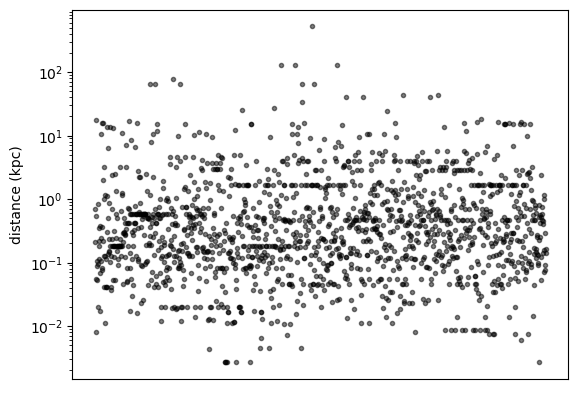

In [15]:
plt.plot(tbl.loc[tbl['distance']!='--']['distance']/1000,'k.',alpha=0.5)
plt.xticks([])
plt.ylabel('distance (kpc)')
plt.semilogy();

Right ascension and declination are given in J2000 decimal degrees.

Offsets are in arcseconds.

The `_n_match` parameters report he number of sources in the correspondin catalog that were within 12.5 arcseconds of the GALEX source position.